# Classification
1. Extract acoustic-prosodic features using openSMILE Toolkit
2. Normalization
3. Build leave-one-speaker-out cross-validation classifier
4. Report classification results, aggregated average accuracy, weighted F1 scores

In [277]:
!pip install xgboost

In [279]:
!pip install lightgbm

In [123]:
import os
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import parselmouth
from parselmouth.praat import call
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.svm import SVC
from collections import defaultdict
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

## Data Description
- File (2,324 Wav)
    - speaker_session_emotion_start-time_content.wav
        - **7 speakers**: cc, cl, gg, jg, mf, mk, mm
            - ex) cc_001_anxiety_910.77_May-twenty-third.wav
                - speaker(cc), session(001), emotion(anxiety), start-time(910.77), content/script(May-twenty-thrid)
        - **15 emotions**: anxiety, boredom, cold-anger, contempt, despair, disgust, elation, happy, hot-anger, interest, neural, panic, pride, sadness, shame

## Feature Extraction
1. Extract a set of **acoustic-prosodic features** using the **openSMILE** toolkit.
    - Create a folder named `features` in the parent directory.
        ```bash
        git clone https://github.com/audeering/opensmile.git
        cd opensmile/
        bash build.sh
        ```
        `opensmile` directory would be created in the parent directory of the (`em3907`) folder.
    - After building, run the following command in the terminal to extract features:
        ```bash
        find ../hw3_speech_files/ -type f -name "*.wav" -exec sh -c 'for file; do base=$(basename "$file" ".wav"); ./build/progsrc/smilextract/SMILExtract -l 1 -C ./config/is09-13/IS09_emotion.conf -I $file -csvoutput "../features/${base}.csv"; done' sh {} +
        ```
    - The extracted features from openSMILE will be saved in the `features` folder in the parent directory.

In [5]:
# check one extracted feature
file_path1 = "../features/cc_001_boredom_2248.50_Eight-thousand-six.csv"

data1 = pd.read_csv(file_path1, sep=";")

print(data1.shape)

(1, 386)


In [7]:
data1.T.head(20)

,0
name,'unknown'
frameTime,0.0
pcm_RMSenergy_sma_max,0.017557
pcm_RMSenergy_sma_min,0.000042
pcm_RMSenergy_sma_range,0.017515
pcm_RMSenergy_sma_maxPos,99
pcm_RMSenergy_sma_minPos,0
pcm_RMSenergy_sma_amean,0.002793
pcm_RMSenergy_sma_linregc1,0.000018
pcm_RMSenergy_sma_linregc2,0.001319


In [9]:
print(data1.columns.tolist())

['name', 'frameTime', 'pcm_RMSenergy_sma_max', 'pcm_RMSenergy_sma_min', 'pcm_RMSenergy_sma_range', 'pcm_RMSenergy_sma_maxPos', 'pcm_RMSenergy_sma_minPos', 'pcm_RMSenergy_sma_amean', 'pcm_RMSenergy_sma_linregc1', 'pcm_RMSenergy_sma_linregc2', 'pcm_RMSenergy_sma_linregerrQ', 'pcm_RMSenergy_sma_stddev', 'pcm_RMSenergy_sma_skewness', 'pcm_RMSenergy_sma_kurtosis', 'pcm_fftMag_mfcc_sma[1]_max', 'pcm_fftMag_mfcc_sma[1]_min', 'pcm_fftMag_mfcc_sma[1]_range', 'pcm_fftMag_mfcc_sma[1]_maxPos', 'pcm_fftMag_mfcc_sma[1]_minPos', 'pcm_fftMag_mfcc_sma[1]_amean', 'pcm_fftMag_mfcc_sma[1]_linregc1', 'pcm_fftMag_mfcc_sma[1]_linregc2', 'pcm_fftMag_mfcc_sma[1]_linregerrQ', 'pcm_fftMag_mfcc_sma[1]_stddev', 'pcm_fftMag_mfcc_sma[1]_skewness', 'pcm_fftMag_mfcc_sma[1]_kurtosis', 'pcm_fftMag_mfcc_sma[2]_max', 'pcm_fftMag_mfcc_sma[2]_min', 'pcm_fftMag_mfcc_sma[2]_range', 'pcm_fftMag_mfcc_sma[2]_maxPos', 'pcm_fftMag_mfcc_sma[2]_minPos', 'pcm_fftMag_mfcc_sma[2]_amean', 'pcm_fftMag_mfcc_sma[2]_linregc1', 'pcm_fftMag_m

In [41]:
feature_dir = "../features"
data = []

for filename in os.listdir(feature_dir):
    if filename.endswith(".csv"):
        parts = filename.replace(".csv", "").split("_", maxsplit=4)
        
        if len(parts) == 5:
            speaker, session, emotion, start_time, content = parts
            filepath = os.path.join(feature_dir, filename)

            df = pd.read_csv(filepath, sep=";")
            feature_vector = df.iloc[0].to_dict()

            feature_vector.update({
                "speaker": speaker,
                "emotion": emotion,
                "content": content,
                "filename": filename.replace(".csv", ".wav")
            })

            data.append(feature_vector)

df = pd.DataFrame(data)

In [42]:
print(df.shape)

(2324, 390)


In [6]:
df.head()

,name,frameTime,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,...,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis,speaker,emotion,content,filename
0,'unknown',0.0,0.010760,0.000064,0.010696,111,165,0.002748,-8.324649e-06,0.003498,...,-0.033835,3.045167,1062.67900,32.646660,-0.090631,4.245496,mm,happy,three-hundred-nine,mm_001_happy_2353.51_three-hundred-nine.wav
1,'unknown',0.0,0.076285,0.000034,0.076251,32,134,0.011488,-1.106844e-04,0.019789,...,-0.097880,7.340973,1683.38700,41.250330,0.000596,4.717154,mm,panic,one-thousand-three,mm_001_panic_3395.30_one-thousand-three.wav
2,'unknown',0.0,0.020006,0.000010,0.019996,39,1853,0.000425,-2.645859e-07,0.000788,...,-0.000025,0.034964,213.41610,14.608780,-0.116606,17.215480,cc,panic,Two-thousand-five,cc_001_panic_861.97_Two-thousand-five.wav
3,'unknown',0.0,0.015069,0.000043,0.015026,85,0,0.005252,2.256441e-05,0.004067,...,-0.029053,1.525273,188.63710,13.763260,-0.312293,6.684447,mf,contempt,November-first,mf_001_contempt_3901.86_November-first.wav
4,'unknown',0.0,0.016625,0.000111,0.016514,55,137,0.002422,-3.115808e-05,0.004572,...,-0.001866,0.128773,39.98518,6.323827,-0.006288,25.196500,cl,interest,Ten-thousand-one,cl_001_interest_1035.82_Ten-thousand-one.wav


In [7]:
print(df["name"].unique())
print(df["frameTime"].unique())

["'unknown'"]
[0.]


In [45]:
df = df.drop(columns=["name", "frameTime"])

first_cols = ["filename", "speaker", "emotion", "content"]
remaining_cols = [col for col in df.columns if col not in first_cols]
df = df[first_cols + remaining_cols]

In [30]:
df.head()

,filename,speaker,emotion,content,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,...,F0_sma_de_range,F0_sma_de_maxPos,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis
0,mm_001_happy_2353.51_three-hundred-nine.wav,mm,happy,three-hundred-nine,0.010760,0.000064,0.010696,111,165,0.002748,...,181.94580,85,92,5.348673e-08,-0.033835,3.045167,1062.67900,32.646660,-0.090631,4.245496
1,mm_001_panic_3395.30_one-thousand-three.wav,mm,panic,one-thousand-three,0.076285,0.000034,0.076251,32,134,0.011488,...,245.74430,85,68,2.589447e-08,-0.097880,7.340973,1683.38700,41.250330,0.000596,4.717154
2,cc_001_panic_861.97_Two-thousand-five.wav,cc,panic,Two-thousand-five,0.020006,0.000010,0.019996,39,1853,0.000425,...,181.56010,1909,617,-9.201901e-09,-0.000025,0.034964,213.41610,14.608780,-0.116606,17.215480
3,mf_001_contempt_3901.86_November-first.wav,mf,contempt,November-first,0.015069,0.000043,0.015026,85,0,0.005252,...,87.32532,62,71,6.747695e-08,-0.029053,1.525273,188.63710,13.763260,-0.312293,6.684447
4,cl_001_interest_1035.82_Ten-thousand-one.wav,cl,interest,Ten-thousand-one,0.016625,0.000111,0.016514,55,137,0.002422,...,74.25951,95,99,1.372193e-08,-0.001866,0.128773,39.98518,6.323827,-0.006288,25.196500


In [47]:
print(df.shape)

(2324, 388)


### Columns Analysis
total = #.of low-level descriptor x #.of functional
1. Low-Level Descriptors (LLDs): 16
    - pcm_RMSenergy
    - mfcc[1-12]
    - pcm_zcr
    - voiceProb
    - F0 
2. Smoothing / Delta
   - _sma: moving average smoothing
   - _sma_de: delta coefficient
3. Statistic Functionals: 12
   - max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis

16 x 2 x 12 = 384 features

In [31]:
llds = [
    "pcm_RMSenergy", "mfcc[1]", "mfcc[2]", "mfcc[3]", "mfcc[4]", "mfcc[5]", "mfcc[6]",
    "mfcc[7]", "mfcc[8]", "mfcc[9]", "mfcc[10]", "mfcc[11]", "mfcc[12]",
    "pcm_zcr", "voiceProb", "F0"
]

smoothing = ["sma", "sma_de"]

functionals = [
    "max", "min", "range", "maxPos", "minPos", "amean",
    "linregc1", "linregc2", "linregerrQ", "stddev", "skewness", "kurtosis"
]

In [33]:
feature_columns = df.columns[3:]

grouped = defaultdict(list)

for col in feature_columns:
    match = re.match(r"(.*)_sma(_de)?(?:\[.*?\])?_([a-zA-Z0-9]+)$", col)
    if match:
        pre, delta, func = match.groups()
        smoothing = "sma_de" if delta else "sma"
        
        mfcc_match = re.search(r"(mfcc(?:\[\d+\]))", col)
        if mfcc_match:
            feature = mfcc_match.group(1)
            base = col.split("_")[0]
            grouped[(base + "_" + feature, smoothing)].append(func)
        else:
            feature = pre
            grouped[(feature, smoothing)].append(func)

In [35]:
rows = []
for (feature, smoothing), functionals in grouped.items():
    rows.append({
        "feature": feature,
        "smoothing": smoothing,
        "functionals": functionals
    })

df_grouped = pd.DataFrame(rows)

In [37]:
pd.set_option('display.max_colwidth', None)

In [39]:
df_grouped

,feature,smoothing,functionals
0,pcm_RMSenergy,sma,"[max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis]"
1,pcm_fftMag_mfcc,sma,"[max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, ...]"
2,pcm_zcr,sma,"[max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis]"
3,voiceProb,sma,"[max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis]"
4,F0,sma,"[max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis]"
5,pcm_RMSenergy,sma_de,"[max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis]"
6,pcm_fftMag_mfcc,sma_de,"[max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis, max, min, range, maxPos, ...]"
7,pcm_zcr,sma_de,"[max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis]"
8,voiceProb,sma_de,"[max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis]"
9,F0,sma_de,"[max, min, range, maxPos, minPos, amean, linregc1, linregc2, linregerrQ, stddev, skewness, kurtosis]"


In [41]:
df.describe()

,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,pcm_RMSenergy_sma_linregerrQ,pcm_RMSenergy_sma_stddev,...,F0_sma_de_range,F0_sma_de_maxPos,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2.324000e+03,2324.000000,...,2324.000000,2324.000000,2324.000000,2.324000e+03,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,0.043794,0.000152,0.043642,55.490964,68.901463,0.008439,-0.000040,0.010951,1.719750e-04,0.009988,...,140.740718,43.879518,50.214286,7.674516e-02,-0.034747,2.191247,626.938384,21.231242,0.021924,8.007449
std,0.037941,0.000212,0.037895,34.129270,73.522468,0.008504,0.000105,0.011644,5.651317e-04,0.009382,...,76.014600,54.546099,41.133139,4.407546e-01,0.048669,2.355608,600.177495,13.407176,0.409073,7.037299
min,0.001692,0.000010,0.001632,0.000000,0.000000,0.000385,-0.000895,-0.014999,1.211983e-07,0.000363,...,0.000000,0.000000,0.000000,-2.038853e+00,-0.412679,-6.706146,0.000000,0.000000,-2.420819,0.000000
25%,0.017835,0.000056,0.017728,29.000000,5.000000,0.003208,-0.000065,0.003858,1.314914e-05,0.003821,...,104.670175,10.000000,20.000000,-3.224450e-08,-0.048642,0.329953,138.490425,11.770055,-0.071170,4.252609
50%,0.033110,0.000096,0.033005,50.000000,60.500000,0.005777,-0.000023,0.007316,4.760378e-05,0.007277,...,151.393000,35.000000,44.000000,0.000000e+00,-0.020868,1.602514,472.820600,21.779635,0.000000,6.273030
75%,0.058762,0.000171,0.058646,77.000000,124.000000,0.010772,-0.000002,0.013917,1.631809e-04,0.013393,...,201.034375,67.000000,75.000000,3.620412e-08,-0.004328,3.299562,951.372775,30.965962,0.111126,9.864332
max,0.536646,0.002924,0.536455,237.000000,1853.000000,0.105401,0.000789,0.164502,2.006912e-02,0.144206,...,255.536300,1909.000000,617.000000,6.511675e+00,0.405595,15.888150,3897.965000,62.747460,5.496580,47.833530


## Normalization
2. **Normalize** your extracted features (as in Part 1.Feature Analysis)
   1. **Z-score normalization** (standardization) over the individual speaker is one common method. For example, if you would like to normalize the pitch features of an individual speaker X, the steps to Z-score normalization can be:
        1. Extract raw pitch values for all speech segments from speaker X. This would result in one array of pitch/frequency values for each segment.
        2. Concatenate all pitch arrays from speaker X and calculate an overall mean pitch (𝜇𝑋) and pitch std (𝜎𝑋) of speaker X.
        3. Normalize each extracted pitch array – for each value 𝒙 in an array, calculate the normalized 𝒙 as (𝒙 - 𝜇𝑋) / 𝜎𝑋.
        4. Finally, calculate the min, max, and mean of pitch for each segment using the normalized pitch array.
        5. *Note: You are supposed to obtain an overall pitch/intensity mean and std value for **each speaker instead of each feature**, in order to normalize by the speaker. Do not get a mean value of mean pitches, rather, get an overall mean value of all pitch values from all segments

    - You can either pick one of the normalization methods above or use other methods you find helpful. Please specify your method and provide a detailed description of how you calculated it and why you chose it. **You should exclude values of pitch and intensity that are 0 or NaN**.

Since openSMILE is not providing raw feature arrays, we can take mean and std of all non 0 and non NaN feature values for a speaker and a feature. And then use the z-score normalization formula to normalize all 0 and non NaN values for that speaker and feature.
1. For each speaker and each feature:
    - Compute the mean (μ) and standard deviation (σ) excluding values that are 0 or NaN.

2. Apply normalization:
    - For each feature value 𝑥, compute the normalized value as: 𝑥_normalized = (𝑥−𝜇)/𝜎 
    - If the value 𝑥 is 0 or NaN, leave it unchanged (i.e., keep it as 0 or NaN after normalization).

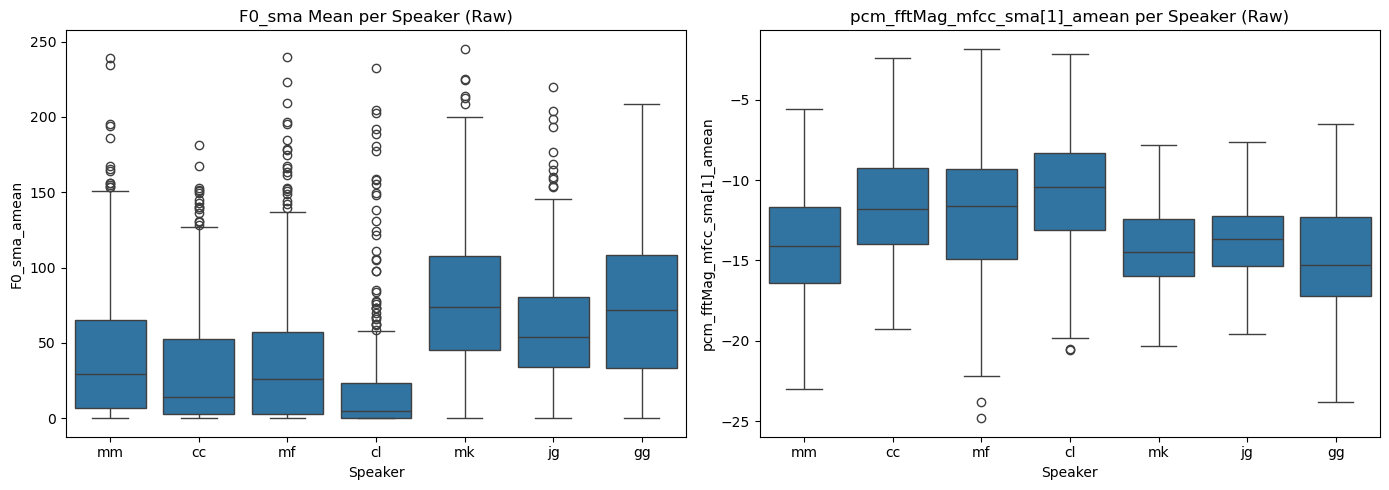

In [45]:
plt.figure(figsize=(14, 5))

# left: F0 mean per speaker
plt.subplot(1, 2, 1)
sns.boxplot(x="speaker", y="F0_sma_amean", data=df)
plt.title("F0_sma Mean per Speaker (Raw)")
plt.xlabel("Speaker")
plt.ylabel("F0_sma_amean")

# right: pcm_RMSenergy mean per speaker
plt.subplot(1, 2, 2)
sns.boxplot(x="speaker", y="pcm_fftMag_mfcc_sma[1]_amean", data=df)
plt.title("pcm_fftMag_mfcc_sma[1]_amean per Speaker (Raw)")
plt.xlabel("Speaker")
plt.ylabel("pcm_fftMag_mfcc_sma[1]_amean")

plt.tight_layout()
plt.show()

In [18]:
# check nan values
nan_counts = df.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("Columns with NaN values:")
print(nan_counts)

Columns with NaN values:
Series([], dtype: int64)


In [20]:
# check 0 values
zero_counts = (df == 0).sum()
zero_counts = zero_counts[zero_counts > 0]
print("\nColumns with zero values:")
print(zero_counts)


Columns with zero values:
pcm_RMSenergy_sma_maxPos               1
pcm_RMSenergy_sma_minPos             324
pcm_fftMag_mfcc_sma[1]_maxPos         17
pcm_fftMag_mfcc_sma[1]_minPos         24
pcm_fftMag_mfcc_sma[2]_maxPos         31
pcm_fftMag_mfcc_sma[2]_minPos          8
pcm_fftMag_mfcc_sma[3]_maxPos         28
pcm_fftMag_mfcc_sma[3]_minPos          6
pcm_fftMag_mfcc_sma[4]_maxPos         90
pcm_fftMag_mfcc_sma[4]_minPos          6
pcm_fftMag_mfcc_sma[5]_maxPos        109
pcm_fftMag_mfcc_sma[5]_minPos          4
pcm_fftMag_mfcc_sma[6]_maxPos        111
pcm_fftMag_mfcc_sma[7]_maxPos         79
pcm_fftMag_mfcc_sma[7]_minPos          2
pcm_fftMag_mfcc_sma[8]_maxPos         54
pcm_fftMag_mfcc_sma[8]_minPos          5
pcm_fftMag_mfcc_sma[9]_maxPos         71
pcm_fftMag_mfcc_sma[9]_minPos          3
pcm_fftMag_mfcc_sma[10]_maxPos        59
pcm_fftMag_mfcc_sma[10]_minPos         3
pcm_fftMag_mfcc_sma[11]_maxPos        64
pcm_fftMag_mfcc_sma[11]_minPos        11
pcm_fftMag_mfcc_sma[12]_maxPos

In [49]:
# drop columns that have zeros over 90%

zero_counts = (df == 0).sum()
features_to_drop = zero_counts[zero_counts > 2000].index.tolist()

print("Dropping features:", features_to_drop)

df = df.drop(columns=features_to_drop)

Dropping features: ['F0_sma_min', 'F0_sma_minPos']


In [51]:
def normalize_feature_by_speaker(df, feature_col):
    normalized = []

    for speaker, group in df.groupby('speaker'):
        values = group[feature_col]
        
        # Exclude 0 and NaN to compute mean and std
        valid_values = values[(values != 0) & (~values.isna())]
        
        if len(valid_values) == 0:
            mean = 0
            std = 1
        else:
            mean = valid_values.mean()
            std = valid_values.std()

        # Normalize
        normalized_values = values.apply(
            lambda x: (x - mean) / std if (std != 0) else x
        )
        
        normalized.append(normalized_values)

    normalized_series = pd.concat(normalized)
    normalized_series = normalized_series.sort_index()  # restore original order
    return normalized_series

In [53]:
feature_columns = [col for col in df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]

normalized_df = df[['filename', 'speaker', 'emotion', 'content']].copy()

normalized_features = []

for feature in feature_columns:
    normalized_feature = normalize_feature_by_speaker(df, feature)
    normalized_features.append(normalized_feature)

normalized_features_df = pd.concat(normalized_features, axis=1)
normalized_df = pd.concat([normalized_df, normalized_features_df], axis=1)

In [54]:
normalized_df.head()

,filename,speaker,emotion,content,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,...,F0_sma_de_range,F0_sma_de_maxPos,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis
0,mm_001_happy_2353.51_three-hundred-nine.wav,mm,happy,three-hundred-nine,-1.083405,-0.515106,-1.080985,1.428270,1.470515,-0.883163,...,0.733511,0.991255,0.863855,0.033961,0.032437,0.353840,0.930931,1.059339,-0.214255,-0.880546
1,mm_001_panic_3395.30_one-thousand-three.wav,mm,panic,one-thousand-three,1.013867,-0.627824,1.021019,-0.951150,0.960971,0.570208,...,2.057040,0.991255,0.153189,0.033961,-1.746160,2.341356,2.113384,1.892238,-0.010294,-0.812158
2,cc_001_panic_861.97_Two-thousand-five.wav,cc,panic,Two-thousand-five,-0.521613,-0.882515,-0.519097,-0.246344,12.067980,-1.356448,...,0.829206,13.872806,11.581959,-0.311367,0.663788,-0.775358,-0.691658,-0.655908,-0.353422,0.992924
3,mf_001_contempt_3901.86_November-first.wav,mf,contempt,November-first,-0.558254,-0.614879,-0.555488,1.207743,-1.544675,-0.338503,...,-1.238277,0.623977,0.684712,-0.236350,0.282295,-0.410302,-0.814805,-0.889750,-0.737977,-0.405946
4,cl_001_interest_1035.82_Ten-thousand-one.wav,cl,interest,Ten-thousand-one,-0.483210,0.438028,-0.483712,-0.451018,0.589581,-0.406632,...,-1.450133,0.467248,0.480168,-0.204109,0.495053,-0.620746,-0.923849,-1.295246,0.081213,0.893177


In [30]:
normalized_df.describe()

,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,pcm_RMSenergy_sma_linregerrQ,pcm_RMSenergy_sma_stddev,...,F0_sma_de_range,F0_sma_de_maxPos,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis
count,2.324000e+03,2.324000e+03,2.324000e+03,2324.000000,2324.000000,2.324000e+03,2.324000e+03,2.324000e+03,2324.000000,2.324000e+03,...,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,7.643532e-18,3.439589e-17,-2.140189e-17,-0.000488,-0.166844,-1.222965e-17,1.796230e-17,2.598801e-17,0.000000,-7.643532e-18,...,-0.474056,-0.238777,-0.299965,-0.036263,0.113325,-0.139639,-0.173078,-0.329136,0.000432,-0.243102
std,9.987077e-01,9.987077e-01,9.987077e-01,0.998770,1.033862,9.987077e-01,9.987077e-01,9.987077e-01,0.998708,9.987077e-01,...,1.441896,1.096111,1.172115,0.904145,0.957184,0.977282,1.003351,1.199994,0.917864,1.077585
min,-1.338204e+00,-1.502783e+00,-1.336815e+00,-1.923504,-2.027016,-1.356448e+00,-9.499291e+00,-1.499677e+00,-0.655848,-1.242699e+00,...,-4.708912,-2.069892,-2.503470,-12.943103,-6.273334,-3.436642,-1.783036,-3.348823,-5.020989,-1.751078
25%,-6.559753e-01,-4.945347e-01,-6.567559e-01,-0.744277,-1.106265,-5.831199e-01,-2.889962e-01,-5.915112e-01,-0.407977,-6.275163e-01,...,-1.288260,-0.948436,-0.972753,-0.258966,-0.207154,-0.760134,-0.958161,-1.186852,-0.231931,-0.855143
50%,-2.885434e-01,-2.396957e-01,-2.894622e-01,-0.176111,-0.264461,-2.897469e-01,1.343692e-01,-3.063900e-01,-0.231060,-2.961224e-01,...,-0.295369,-0.332135,-0.409421,-0.204109,0.398419,-0.419192,-0.450375,-0.323274,0.001373,-0.455574
75%,4.211244e-01,1.809161e-01,4.218061e-01,0.600610,0.694185,2.785326e-01,4.189933e-01,2.828591e-01,-0.003379,3.563955e-01,...,0.632159,0.332044,0.362490,-0.071461,0.661137,0.312399,0.334985,0.499090,0.195484,0.143609
max,1.090463e+01,8.513464e+00,1.090090e+01,5.492993,12.067980,1.138985e+01,8.891960e+00,1.050065e+01,17.466914,1.181362e+01,...,2.260009,13.872806,11.581959,15.010537,5.949994,4.458962,5.019328,3.771049,9.930324,7.284519


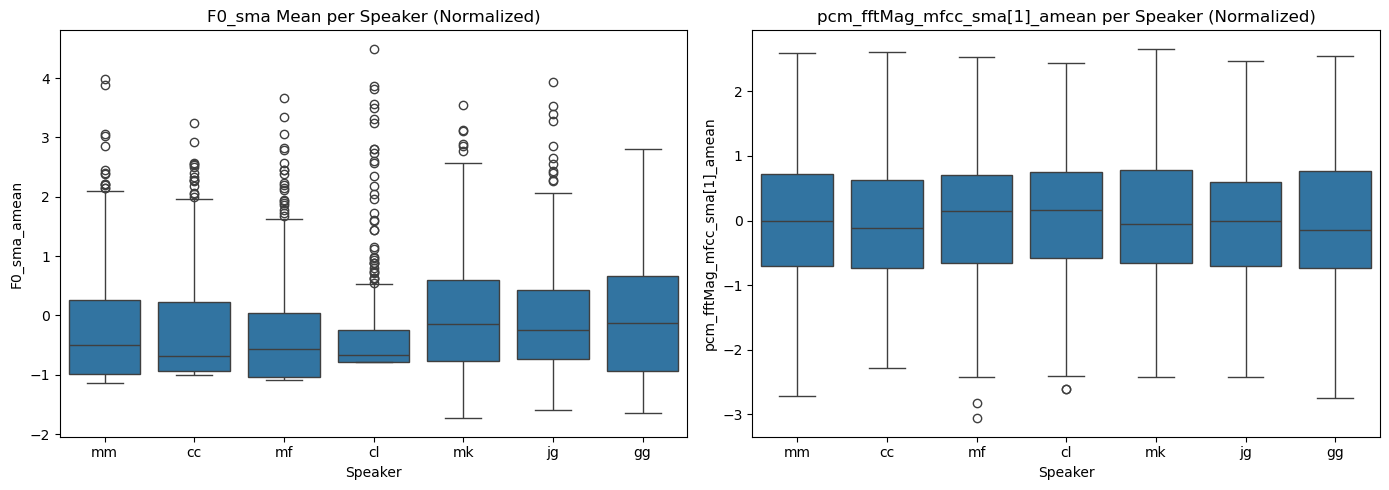

In [61]:
plt.figure(figsize=(14, 5))

# left: F0 mean per speaker
plt.subplot(1, 2, 1)
sns.boxplot(x="speaker", y="F0_sma_amean", data=normalized_df)
plt.title("F0_sma Mean per Speaker (Normalized)")
plt.xlabel("Speaker")
plt.ylabel("F0_sma_amean")

# right: pcm_RMSenergy mean per speaker
plt.subplot(1, 2, 2)
sns.boxplot(x="speaker", y="pcm_fftMag_mfcc_sma[1]_amean", data=normalized_df)
plt.title("pcm_fftMag_mfcc_sma[1]_amean per Speaker (Normalized)")
plt.xlabel("Speaker")
plt.ylabel("pcm_fftMag_mfcc_sma[1]_amean")

plt.tight_layout()
plt.show()

## Classification and Result
3. and use **leave-one-speaker-out cross-validation** to predict the emotion classes. Leave-one-speaker-out cross-validation means, for each speaker S, train on all other six other speakers combined and test on S.
4. Report the **classification results** (screenshot or copy-paste sklearn classification reports) for all 7 experiments (leave one speaker out as the test set in each experiment).
5. Also, compute and report **aggregated average accuracy** and **weighted F1 scores** over all the experiments and emotions.
    - The aggregated metrics should be calculated as follows:
      𝒂𝒈𝒈𝒓𝒆𝒈𝒂𝒕𝒆𝒅 𝒂𝒗𝒆𝒓𝒂𝒈𝒆 𝒂𝒄𝒄𝒖𝒓𝒂𝒄𝒚 = ∑(𝒂𝒄𝒄𝒊 ⋅ 𝒏𝒊) / ∑𝒏𝒊
      𝒂𝒈𝒈𝒓𝒆𝒈𝒂𝒕𝒆𝒅 𝒂𝒗𝒆𝒓𝒂𝒈𝒆 𝑭𝟏 = ∑(𝑭𝟏𝒊 ⋅ 𝒏𝒊) / ∑𝒏𝒊
      Here, 𝑎𝑐𝑐𝑖 and 𝐹1𝑖 represent the accuracy and weighted F1 scores for the test set of speaker S in each run, and 𝑛𝑖 is the number of samples in the corresponding test set.

In [57]:
# label encoding
le = LabelEncoder()
normalized_df["emotion"] = le.fit_transform(normalized_df["emotion"])

In [34]:
le.classes_

array(['anxiety', 'boredom', 'cold-anger', 'contempt', 'despair',
       'disgust', 'elation', 'happy', 'hot-anger', 'interest', 'neutral',
       'panic', 'pride', 'sadness', 'shame'], dtype=object)

In [36]:
print(normalized_df[['speaker', 'emotion']].head())

  speaker  emotion
0      mm        7
1      mm       11
2      cc       11
3      mf        3
4      cl        9


In [38]:
def calculate_metrics(results_df):
    
    # Aggregated metrics
    total_samples = results_df['n_samples'].sum()
    
    aggregated_accuracy = np.sum(results_df['accuracy'] * results_df['n_samples']) / total_samples
    aggregated_f1 = np.sum(results_df['f1'] * results_df['n_samples']) / total_samples

    # Print final results
    print("\n--- Aggregated Results ---")
    print(f"Aggregated Accuracy: {aggregated_accuracy:.4f}")
    print(f"Aggregated Weighted F1: {aggregated_f1:.4f}")
    
    return aggregated_accuracy, aggregated_f1

In [42]:
# baseline without using additional features as well as preprocessing

def leave_one_speaker_out_cv_v2(df, feature_columns, label_column='emotion', speaker_column='speaker'):
    speakers = df[speaker_column].unique()
    results = defaultdict(list)

    for speaker in speakers:
        # Train/Test split
        train_df = df[df[speaker_column] != speaker]
        test_df = df[df[speaker_column] == speaker]
        
        X_train = train_df[feature_columns]
        y_train = train_df[label_column]
        X_test = test_df[feature_columns]
        y_test = test_df[label_column]
        
        n_samples = len(y_test)
        
        # Model 1: Random Forest
        rf_model = RandomForestClassifier(random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred_rf = rf_model.predict(X_test)
        acc_rf = accuracy_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
        
        # Model 2: SVM
        svm_model = SVC(kernel='rbf', random_state=42, class_weight="balanced")
        svm_model.fit(X_train, y_train)
        y_pred_svm = svm_model.predict(X_test)
        acc_svm = accuracy_score(y_test, y_pred_svm)
        f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
        
        # Save results
        results['speaker'].append(speaker)
        results['n_samples'].append(n_samples)
        
        results['rf_accuracy'].append(acc_rf)
        results['rf_f1'].append(f1_rf)
        
        results['svm_accuracy'].append(acc_svm)
        results['svm_f1'].append(f1_svm)
        
        # Print classification reports
        print(f"\n==== Speaker {speaker} (Random Forest) ====")
        print(classification_report(y_test, y_pred_rf, zero_division=0))
        
        print(f"\n==== Speaker {speaker} (SVM) ====")
        print(classification_report(y_test, y_pred_svm, zero_division=0))

    # results
    results_df = pd.DataFrame(results)
    
    # Aggregated metrics
    total_samples = results_df['n_samples'].sum()
    
    aggregated_rf_accuracy = np.sum(results_df['rf_accuracy'] * results_df['n_samples']) / total_samples
    aggregated_rf_f1 = np.sum(results_df['rf_f1'] * results_df['n_samples']) / total_samples
    
    aggregated_svm_accuracy = np.sum(results_df['svm_accuracy'] * results_df['n_samples']) / total_samples
    aggregated_svm_f1 = np.sum(results_df['svm_f1'] * results_df['n_samples']) / total_samples

    # Print final results
    print("\n--- Aggregated Results ---")
    print(f"Random Forest Aggregated Accuracy: {aggregated_rf_accuracy:.4f}")
    print(f"Random Forest Aggregated Weighted F1: {aggregated_rf_f1:.4f}")
    
    print(f"SVM Aggregated Accuracy: {aggregated_svm_accuracy:.4f}")
    print(f"SVM Aggregated Weighted F1: {aggregated_svm_f1:.4f}")
    
    return results_df

In [44]:
feature_columns1 = normalized_df.columns.difference(['filename', 'speaker', 'emotion', 'content'])
results_df = leave_one_speaker_out_cv_v2(normalized_df, feature_columns1)


==== Speaker mm (Random Forest) ====
              precision    recall  f1-score   support

           0       0.47      0.21      0.29        39
           1       0.30      0.37      0.33        19
           2       0.22      0.10      0.14        20
           3       0.10      0.11      0.10        19
           4       0.32      0.39      0.35        18
           5       0.45      0.22      0.29        23
           6       0.38      0.32      0.34        19
           7       0.26      0.50      0.34        18
           8       0.33      0.38      0.35        16
           9       0.20      0.38      0.26        21
          10       0.00      0.00      0.00         9
          11       0.56      0.32      0.41        28
          12       0.12      0.11      0.11        19
          13       0.11      0.18      0.14        17
          14       0.33      0.59      0.43        17

    accuracy                           0.28       302
   macro avg       0.28      0.28      0.2

- performance
    - Random Forest: Aggregated Accuracy (0.2048), Aggregated Weighted F1 (0.1995)
    - SVM: Aggregated Accuracy (0.2590), Aggregated Weighted F1 (0.2546)

SVM is better than Random Forest

## Further analysis / experiments
- **Features**: You may supplement the openSMILE features with additional features, such as textual features or other speech-related features. However, **please note that the openSMILE features must be included**. Ensure that you provide a clear justification for your feature selection and include a detailed description of all features in your report.
- **Classification Model**: You can train a multiclass classifier and use the classification report function in sklearn to generate the results. Regarding the classifier, you can use either a traditional machine learning model, such as random forest and SVM, or a neural network model. Report the type and structure of the model you use. Please avoid excessive tuning of the hyperparameters of the classifier you use, since you want to avoid overfitting the dataset.
    - Notes: try your **best** for the model performance and report the best aggregated average accuracy and aggregated average weighted F1 score.

### Preprocessing
- Outlier
- class imbalance
- feature selection
- additional feature

In [18]:
def leave_one_speaker_out_cv_v2_noReport(df, feature_columns, label_column='emotion', speaker_column='speaker'):
    speakers = df[speaker_column].unique()
    results = defaultdict(list)

    for speaker in speakers:
        # Train/Test split
        train_df = df[df[speaker_column] != speaker]
        test_df = df[df[speaker_column] == speaker]
        
        X_train = train_df[feature_columns]
        y_train = train_df[label_column]
        X_test = test_df[feature_columns]
        y_test = test_df[label_column]
        
        n_samples = len(y_test)
        
        # Model 2: SVM
        svm_model = SVC(kernel='rbf', random_state=42, class_weight="balanced")
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Save results
        results['speaker'].append(speaker)
        results['n_samples'].append(n_samples)
        
        results['accuracy'].append(acc)
        results['f1'].append(f1)
        

    # results
    results_df = pd.DataFrame(results)
    
    # Aggregated metrics
    total_samples = results_df['n_samples'].sum()

    aggregated_accuracy = np.sum(results_df['accuracy'] * results_df['n_samples']) / total_samples
    aggregated_f1 = np.sum(results_df['f1'] * results_df['n_samples']) / total_samples

    # Print final results
    print("\n--- Aggregated Results ---")
    print(f"SVM Aggregated Accuracy: {aggregated_accuracy:.4f}")
    print(f"SVM Aggregated Weighted F1: {aggregated_f1:.4f}")
    
    return aggregated_accuracy, aggregated_f1

### 1) Outlier

In [51]:
# 1) outlier
def check_outlier_counts(df, feature_columns, threshold=3):
    outlier_summary = {}

    for col in feature_columns:
        outlier_count = ((df[col] > threshold) | (df[col] < -threshold)).sum()
        total_count = df[col].shape[0]
        outlier_ratio = outlier_count / total_count
        outlier_summary[col] = {
            'outlier_count': outlier_count,
            'total_count': total_count,
            'outlier_ratio (%)': round(outlier_ratio * 100, 2)
        }

    outlier_df = pd.DataFrame(outlier_summary).T
    outlier_df = outlier_df.sort_values(by='outlier_ratio (%)', ascending=False)
    return outlier_df

In [53]:
feature_columns = [col for col in normalized_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]
outlier_stats = check_outlier_counts(normalized_df, feature_columns, threshold=3)

print(outlier_stats)

                               outlier_count  total_count  outlier_ratio (%)
F0_sma_de_range                         89.0       2324.0               3.83
F0_sma_de_min                           89.0       2324.0               3.83
pcm_RMSenergy_sma_min                   53.0       2324.0               2.28
pcm_RMSenergy_sma_linregc2              50.0       2324.0               2.15
pcm_zcr_sma_de_amean                    49.0       2324.0               2.11
...                                      ...          ...                ...
voiceProb_sma_stddev                     2.0       2324.0               0.09
pcm_fftMag_mfcc_sma[3]_max               2.0       2324.0               0.09
pcm_fftMag_mfcc_sma_de[1]_max            2.0       2324.0               0.09
pcm_fftMag_mfcc_sma[1]_amean             1.0       2324.0               0.04
pcm_zcr_sma_stddev                       1.0       2324.0               0.04

[382 rows x 3 columns]


In [16]:
# clipping outlier
def clip_outliers_after_normalization(df, feature_columns, threshold=3):
    df_clipped = df.copy()

    df_clipped[feature_columns] = df_clipped[feature_columns].clip(lower=-threshold, upper=threshold)

    return df_clipped

In [52]:
feature_columns = [col for col in normalized_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]
clipped_df = clip_outliers_after_normalization(normalized_df, feature_columns, threshold=3)

print(f"Before clipping: {normalized_df.shape}")
print(f"After clipping: {clipped_df.shape}")

Before clipping: (2324, 386)
After clipping: (2324, 386)


In [54]:
feature_columns1 = clipped_df.columns.difference(['filename', 'speaker', 'emotion', 'content'])
results_df = leave_one_speaker_out_cv_v2_noReport(clipped_df, feature_columns1)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2603
SVM Aggregated Weighted F1: 0.2562


### 2) Class imbalance

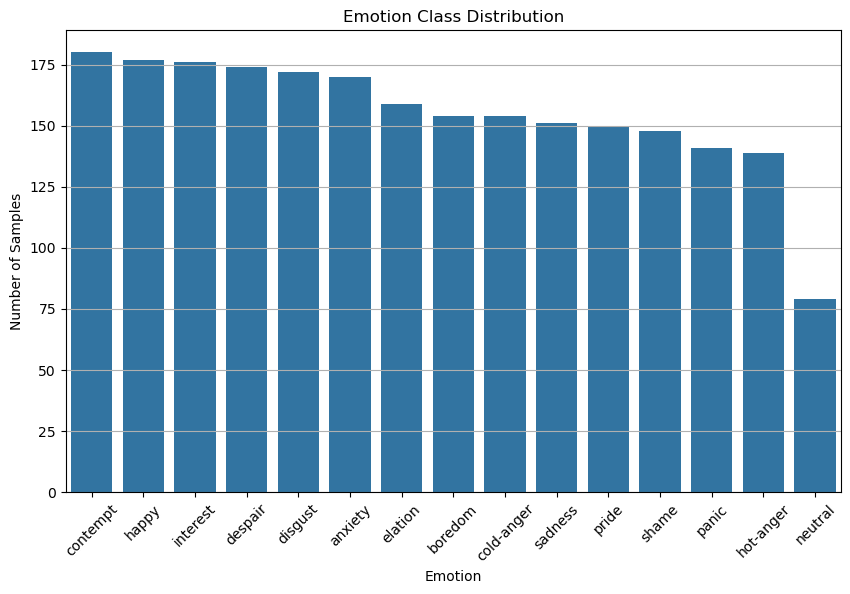

In [61]:
# 2) check class imbalanced
emotion_counts = df['emotion'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title("Emotion Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [63]:
print(emotion_counts)

emotion
contempt      180
happy         177
interest      176
despair       174
disgust       172
anxiety       170
elation       159
boredom       154
cold-anger    154
sadness       151
pride         150
shame         148
panic         141
hot-anger     139
neutral        79
Name: count, dtype: int64


In [65]:
print(le.classes_)

['anxiety' 'boredom' 'cold-anger' 'contempt' 'despair' 'disgust' 'elation'
 'happy' 'hot-anger' 'interest' 'neutral' 'panic' 'pride' 'sadness'
 'shame']


In [67]:
target_class_idx = list(le.classes_).index("neutral")
print(target_class_idx)

10


In [14]:
from imblearn.over_sampling import SMOTE
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

def leave_one_speaker_out_cv_v2_smote(df, feature_columns, label_column='emotion', speaker_column='speaker',
                                      target_size_per_class=None, smote_k_neighbors=5):
    speakers = df[speaker_column].unique()
    results = defaultdict(list)

    for speaker in speakers:
        # Train/Test split
        train_df = df[df[speaker_column] != speaker]
        test_df = df[df[speaker_column] == speaker]

        X_train = train_df[feature_columns]
        y_train = train_df[label_column]
        X_test = test_df[feature_columns]
        y_test = test_df[label_column]

        n_samples = len(y_test)

        # ===== SMOTE oversampling (Train set only) =====
        smote = SMOTE(k_neighbors=smote_k_neighbors, random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        # ===== End oversampling =====

        # Model: SVM
        svm_model = SVC(kernel='rbf', random_state=42, class_weight="balanced")
        svm_model.fit(X_train_resampled, y_train_resampled)
        y_pred = svm_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Save results
        results['speaker'].append(speaker)
        results['n_samples'].append(n_samples)
        results['accuracy'].append(acc)
        results['f1'].append(f1)

    # results
    results_df = pd.DataFrame(results)
    total_samples = results_df['n_samples'].sum()

    aggregated_accuracy = (results_df['accuracy'] * results_df['n_samples']).sum() / total_samples
    aggregated_f1 = (results_df['f1'] * results_df['n_samples']).sum() / total_samples

    # Print final results
    print("\n--- Aggregated Results ---")
    print(f"SVM Aggregated Accuracy: {aggregated_accuracy:.4f}")
    print(f"SVM Aggregated Weighted F1: {aggregated_f1:.4f}")

    return aggregated_accuracy, aggregated_f1


In [46]:
feature_columns = [col for col in df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]
agg_acc, agg_f1 = leave_one_speaker_out_cv_v2_smote(
    normalized_df, feature_columns,
    label_column='emotion', speaker_column='speaker',
    smote_k_neighbors=10)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2595
SVM Aggregated Weighted F1: 0.2544


In [56]:
clipped_balanced_df = leave_one_speaker_out_cv_v2_smote(
    clipped_df, feature_columns,
    label_column='emotion', speaker_column='speaker',
    smote_k_neighbors=10)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2599
SVM Aggregated Weighted F1: 0.2552


### 3) Feature Selection

In [12]:
# 3) Feature Selection
def select_top_k_features_by_importance(df, feature_columns, label_column='emotion', k=30):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(df[feature_columns], df[label_column])
    
    # extract Feature Importance
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    top_k_features = feature_importance_df.head(k)
    
    plt.figure(figsize=(10, 8))
    plt.barh(top_k_features['feature'][::-1], top_k_features['importance'][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {k} Important Features (Random Forest)')
    plt.tight_layout()
    plt.show()
    
    return top_k_features['feature'].tolist()

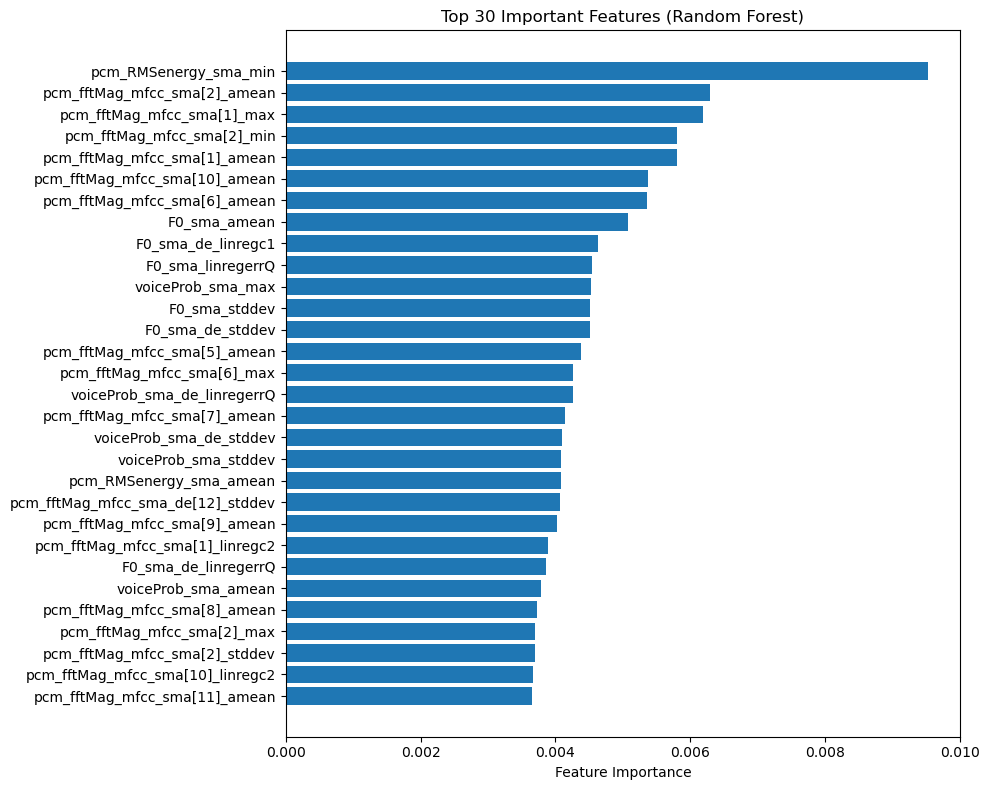

In [271]:
# top features 30
feature_columns = [col for col in clipped_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]

top_features30 = select_top_k_features_by_importance(clipped_df, feature_columns, label_column='emotion', k=30)

In [281]:
results_df = leave_one_speaker_out_cv_v2_smote(clipped_df, top_features30)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2281
SVM Aggregated Weighted F1: 0.2200


In [10]:
def select_top_k_features_by_importance_noReport(df, feature_columns, label_column='emotion', k=30):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(df[feature_columns], df[label_column])
    
    # extract Feature Importance
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    top_k_features = feature_importance_df.head(k)
    
    return top_k_features['feature'].tolist()

In [64]:
acc_scores = []
f1_scores = []

k_list = [50, 100, 150, 200, 220, 250, 280, 300]

for k in k_list:
    top_features_k = select_top_k_features_by_importance_noReport(clipped_df, feature_columns, label_column='emotion', k=k)
    aggregated_accuracy, aggregated_f1 = leave_one_speaker_out_cv_v2_smote(clipped_df, top_features_k)

    acc_scores.append(aggregated_accuracy)
    f1_scores.append(aggregated_f1)
    
com1 = pd.DataFrame({
    'k': k_list,
    'Aggregated Accuracy': acc_scores,
    'Aggregated F1': f1_scores
})


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2509
SVM Aggregated Weighted F1: 0.2437

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2750
SVM Aggregated Weighted F1: 0.2681

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2728
SVM Aggregated Weighted F1: 0.2671

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2784
SVM Aggregated Weighted F1: 0.2718

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2840
SVM Aggregated Weighted F1: 0.2788

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2788
SVM Aggregated Weighted F1: 0.2737

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2831
SVM Aggregated Weighted F1: 0.2787

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2758
SVM Aggregated Weighted F1: 0.2714


In [284]:
com1

,k,Aggregated Accuracy,Aggregated F1
0,50,0.250861,0.243729
1,100,0.274957,0.268059
2,150,0.272806,0.267075
3,200,0.278399,0.271778
4,220,0.283993,0.278828
5,250,0.278830,0.273729
6,280,0.283133,0.278722
7,300,0.275818,0.271390


best k = 220

In [127]:
# clipped + feature200

top_features_k = select_top_k_features_by_importance_noReport(clipped_df, feature_columns, label_column='emotion', k=200)
aggregated_accuracy, aggregated_f1 = leave_one_speaker_out_cv_v2_noReport(clipped_df, top_features_k)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2724
SVM Aggregated Weighted F1: 0.2650


In [129]:
print(top_features_k)

['pcm_RMSenergy_sma_min', 'pcm_fftMag_mfcc_sma[2]_amean', 'pcm_fftMag_mfcc_sma[1]_max', 'pcm_fftMag_mfcc_sma[2]_min', 'pcm_fftMag_mfcc_sma[1]_amean', 'pcm_fftMag_mfcc_sma[10]_amean', 'pcm_fftMag_mfcc_sma[6]_amean', 'F0_sma_amean', 'F0_sma_de_linregc1', 'F0_sma_linregerrQ', 'voiceProb_sma_max', 'F0_sma_stddev', 'F0_sma_de_stddev', 'pcm_fftMag_mfcc_sma[5]_amean', 'pcm_fftMag_mfcc_sma[6]_max', 'voiceProb_sma_de_linregerrQ', 'pcm_fftMag_mfcc_sma[7]_amean', 'voiceProb_sma_de_stddev', 'voiceProb_sma_stddev', 'pcm_RMSenergy_sma_amean', 'pcm_fftMag_mfcc_sma_de[12]_stddev', 'pcm_fftMag_mfcc_sma[9]_amean', 'pcm_fftMag_mfcc_sma[1]_linregc2', 'F0_sma_de_linregerrQ', 'voiceProb_sma_amean', 'pcm_fftMag_mfcc_sma[8]_amean', 'pcm_fftMag_mfcc_sma[2]_max', 'pcm_fftMag_mfcc_sma[2]_stddev', 'pcm_fftMag_mfcc_sma[10]_linregc2', 'pcm_fftMag_mfcc_sma[11]_amean', 'pcm_fftMag_mfcc_sma[1]_stddev', 'pcm_RMSenergy_sma_linregerrQ', 'pcm_fftMag_mfcc_sma[9]_max', 'pcm_RMSenergy_sma_max', 'pcm_fftMag_mfcc_sma[1]_range'

In [290]:
# clipped + feature190

top_features_k = select_top_k_features_by_importance_noReport(clipped_df, feature_columns, label_column='emotion', k=190)
aggregated_accuracy, aggregated_f1 = leave_one_speaker_out_cv_v2_noReport(clipped_df, top_features_k)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2806
SVM Aggregated Weighted F1: 0.2736


In [292]:
# clipped + feature220

top_features_k = select_top_k_features_by_importance_noReport(clipped_df, feature_columns, label_column='emotion', k=220)
aggregated_accuracy, aggregated_f1 = leave_one_speaker_out_cv_v2_noReport(clipped_df, top_features_k)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2784
SVM Aggregated Weighted F1: 0.2707


best so far: clipped + balanced + feature 220
- aggregate accuracy: 0.283993
- aggregated weighted f1: 0.278828

### 4) hyperparameter tuning 1

In [303]:
# 4) hyperparameter tuning

def leave_one_speaker_out_cv_with_params(df, feature_columns, label_column='emotion', speaker_column='speaker', C=1.0, gamma='scale', kernel="rgf"):
    speakers = df[speaker_column].unique()
    results = defaultdict(list)

    for speaker in speakers:
        # Train/Test split
        train_df = df[df[speaker_column] != speaker]
        test_df = df[df[speaker_column] == speaker]
        
        X_train = train_df[feature_columns]
        y_train = train_df[label_column]
        X_test = test_df[feature_columns]
        y_test = test_df[label_column]

        # ===== SMOTE oversampling (Train set only) =====
        smote = SMOTE(k_neighbors=5, random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        # ===== End oversampling =====
        
        n_samples = len(y_test)
        
        # Model 2: SVM with specific C and gamma
        svm_model = SVC(C=C, gamma=gamma, kernel=kernel, random_state=42, class_weight="balanced")
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Save results
        results['speaker'].append(speaker)
        results['n_samples'].append(n_samples)
        results['accuracy'].append(acc)
        results['f1'].append(f1)

    # results
    results_df = pd.DataFrame(results)
    
    # Aggregated metrics
    total_samples = results_df['n_samples'].sum()

    aggregated_accuracy = np.sum(results_df['accuracy'] * results_df['n_samples']) / total_samples
    aggregated_f1 = np.sum(results_df['f1'] * results_df['n_samples']) / total_samples

    return aggregated_accuracy, aggregated_f1

In [305]:
C_list = [1, 10, 100]
gamma_list = [0.001, 0.01]
kernel_list = ["linear", "poly", "rbf", "sigmoid"]

best_f1 = -1
best_params = None

for C in C_list:
    for gamma in gamma_list:
        for kernel in kernel_list:
            agg_acc, agg_f1 = leave_one_speaker_out_cv_with_params(clipped_df, top_features_k, C=C, gamma=gamma, kernel=kernel)
            print(f"C={C}, gamma={gamma} => Aggregated Accuracy: {agg_acc:.4f}, Aggregated F1: {agg_f1:.4f}")
            
            if agg_f1 > best_f1:
                best_f1 = agg_f1
                best_params = (C, gamma, kernel)

print(f"\n Best SVM Params: C={best_params[0]}, gamma={best_params[1]}, kernel={best_params[2]} (Aggregated F1: {best_f1:.4f})")


C=1, gamma=0.001 => Aggregated Accuracy: 0.2203, Aggregated F1: 0.2169
C=1, gamma=0.001 => Aggregated Accuracy: 0.0744, Aggregated F1: 0.0154
C=1, gamma=0.001 => Aggregated Accuracy: 0.2586, Aggregated F1: 0.2492
C=1, gamma=0.001 => Aggregated Accuracy: 0.2491, Aggregated F1: 0.2386
C=1, gamma=0.01 => Aggregated Accuracy: 0.2203, Aggregated F1: 0.2169
C=1, gamma=0.01 => Aggregated Accuracy: 0.2362, Aggregated F1: 0.2301
C=1, gamma=0.01 => Aggregated Accuracy: 0.2595, Aggregated F1: 0.2521
C=1, gamma=0.01 => Aggregated Accuracy: 0.2091, Aggregated F1: 0.1978
C=10, gamma=0.001 => Aggregated Accuracy: 0.2203, Aggregated F1: 0.2169
C=10, gamma=0.001 => Aggregated Accuracy: 0.1222, Aggregated F1: 0.0802
C=10, gamma=0.001 => Aggregated Accuracy: 0.2629, Aggregated F1: 0.2585
C=10, gamma=0.001 => Aggregated Accuracy: 0.2483, Aggregated F1: 0.2431
C=10, gamma=0.01 => Aggregated Accuracy: 0.2203, Aggregated F1: 0.2169
C=10, gamma=0.01 => Aggregated Accuracy: 0.2358, Aggregated F1: 0.2295
C=10, 

### 5) Additional Features
1. features from task 1
2. text-based features

1. features from task 1

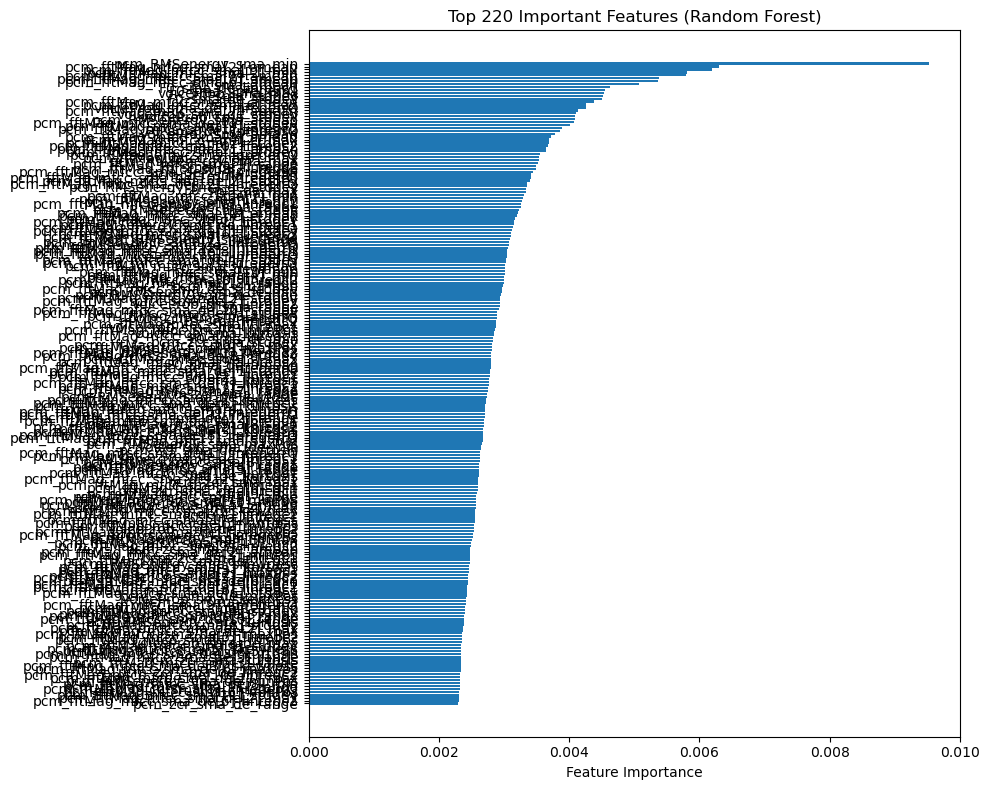


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2840
SVM Aggregated Weighted F1: 0.2788


In [307]:
# best: balanced + features220
# model params: SVC(kernel='rbf', random_state=42) default: C=1.0, gamma="scale"

top_features_220 = select_top_k_features_by_importance(clipped_df, feature_columns, label_column='emotion', k=220)
aggregated_accuracy, aggregated_f1 = leave_one_speaker_out_cv_v2_smote(clipped_df, top_features_220)

In [ ]:
print(top_feature_220)

In [133]:
top_features_200 = ['pcm_RMSenergy_sma_min',
 'pcm_fftMag_mfcc_sma[1]_max',
 'pcm_fftMag_mfcc_sma[2]_amean',
 'pcm_fftMag_mfcc_sma[1]_amean',
 'pcm_fftMag_mfcc_sma[6]_amean',
 'pcm_fftMag_mfcc_sma[2]_min',
 'voiceProb_sma_max',
 'F0_sma_amean',
 'F0_sma_linregerrQ',
 'F0_sma_de_linregc1',
 'pcm_fftMag_mfcc_sma[10]_amean',
 'pcm_fftMag_mfcc_sma[7]_amean',
 'F0_sma_de_linregerrQ',
 'F0_sma_de_linregc2',
 'F0_sma_stddev',
 'pcm_fftMag_mfcc_sma[1]_stddev',
 'pcm_fftMag_mfcc_sma[9]_amean',
 'pcm_fftMag_mfcc_sma[11]_amean',
 'pcm_fftMag_mfcc_sma[8]_linregc2',
 'voiceProb_sma_stddev',
 'voiceProb_sma_de_linregerrQ',
 'pcm_RMSenergy_sma_stddev',
 'voiceProb_sma_range',
 'pcm_fftMag_mfcc_sma_de[1]_linregerrQ',
 'pcm_fftMag_mfcc_sma[1]_linregc2',
 'F0_sma_max',
 'voiceProb_sma_de_stddev',
 'pcm_RMSenergy_sma_max',
 'pcm_fftMag_mfcc_sma[9]_linregerrQ',
 'pcm_RMSenergy_sma_de_linregc1',
 'pcm_zcr_sma_amean',
 'pcm_fftMag_mfcc_sma_de[2]_stddev',
 'voiceProb_sma_amean',
 'pcm_fftMag_mfcc_sma[6]_max',
 'pcm_RMSenergy_sma_amean',
 'pcm_fftMag_mfcc_sma[7]_max',
 'pcm_fftMag_mfcc_sma[2]_stddev',
 'pcm_fftMag_mfcc_sma[4]_amean',
 'pcm_fftMag_mfcc_sma_de[2]_linregerrQ',
 'pcm_fftMag_mfcc_sma[2]_max',
 'pcm_fftMag_mfcc_sma[1]_range',
 'pcm_fftMag_mfcc_sma_de[1]_stddev',
 'pcm_fftMag_mfcc_sma[7]_min',
 'F0_sma_de_stddev',
 'F0_sma_de_amean',
 'pcm_fftMag_mfcc_sma[5]_amean',
 'pcm_fftMag_mfcc_sma_de[7]_stddev',
 'pcm_fftMag_mfcc_sma[11]_min',
 'pcm_fftMag_mfcc_sma_de[10]_stddev',
 'pcm_fftMag_mfcc_sma[6]_linregc2',
 'pcm_fftMag_mfcc_sma[2]_linregerrQ',
 'voiceProb_sma_linregerrQ',
 'pcm_RMSenergy_sma_de_linregc2',
 'pcm_fftMag_mfcc_sma[8]_min',
 'pcm_fftMag_mfcc_sma[7]_linregerrQ',
 'pcm_fftMag_mfcc_sma_de[4]_skewness',
 'pcm_fftMag_mfcc_sma_de[1]_max',
 'pcm_RMSenergy_sma_de_linregerrQ',
 'pcm_fftMag_mfcc_sma[8]_amean',
 'pcm_fftMag_mfcc_sma[5]_min',
 'pcm_fftMag_mfcc_sma[4]_min',
 'pcm_fftMag_mfcc_sma[1]_linregerrQ',
 'pcm_fftMag_mfcc_sma_de[12]_stddev',
 'pcm_fftMag_mfcc_sma[10]_min',
 'pcm_RMSenergy_sma_linregc2',
 'pcm_RMSenergy_sma_range',
 'pcm_fftMag_mfcc_sma[3]_min',
 'pcm_RMSenergy_sma_de_max',
 'pcm_fftMag_mfcc_sma_de[12]_linregerrQ',
 'pcm_fftMag_mfcc_sma[11]_linregc2',
 'F0_sma_de_max',
 'pcm_fftMag_mfcc_sma[12]_stddev',
 'pcm_zcr_sma_min',
 'pcm_fftMag_mfcc_sma_de[10]_linregc1',
 'pcm_fftMag_mfcc_sma_de[4]_stddev',
 'pcm_fftMag_mfcc_sma[7]_stddev',
 'pcm_RMSenergy_sma_linregerrQ',
 'pcm_fftMag_mfcc_sma_de[4]_linregerrQ',
 'pcm_RMSenergy_sma_de_stddev',
 'voiceProb_sma_de_linregc2',
 'pcm_fftMag_mfcc_sma_de[10]_linregerrQ',
 'pcm_fftMag_mfcc_sma_de[3]_stddev',
 'pcm_fftMag_mfcc_sma[12]_range',
 'pcm_zcr_sma_linregerrQ',
 'pcm_fftMag_mfcc_sma[12]_amean',
 'pcm_fftMag_mfcc_sma[9]_min',
 'voiceProb_sma_de_linregc1',
 'pcm_fftMag_mfcc_sma[9]_max',
 'pcm_fftMag_mfcc_sma[9]_range',
 'pcm_fftMag_mfcc_sma[2]_linregc1',
 'pcm_fftMag_mfcc_sma_de[7]_linregerrQ',
 'pcm_RMSenergy_sma_kurtosis',
 'pcm_fftMag_mfcc_sma_de[5]_linregc1',
 'pcm_fftMag_mfcc_sma_de[6]_linregc2',
 'pcm_fftMag_mfcc_sma[5]_max',
 'pcm_RMSenergy_sma_de_range',
 'pcm_zcr_sma_range',
 'pcm_fftMag_mfcc_sma[9]_linregc2',
 'pcm_fftMag_mfcc_sma[9]_stddev',
 'F0_sma_range',
 'pcm_fftMag_mfcc_sma_de[10]_linregc2',
 'pcm_RMSenergy_sma_de_maxPos',
 'voiceProb_sma_linregc1',
 'pcm_fftMag_mfcc_sma[2]_range',
 'pcm_fftMag_mfcc_sma_de[2]_linregc2',
 'pcm_fftMag_mfcc_sma[11]_linregerrQ',
 'pcm_fftMag_mfcc_sma[7]_linregc2',
 'F0_sma_de_range',
 'pcm_RMSenergy_sma_skewness',
 'pcm_zcr_sma_de_linregc1',
 'pcm_zcr_sma_kurtosis',
 'pcm_fftMag_mfcc_sma_de[2]_min',
 'pcm_fftMag_mfcc_sma[10]_max',
 'pcm_fftMag_mfcc_sma_de[2]_kurtosis',
 'pcm_fftMag_mfcc_sma[8]_max',
 'pcm_fftMag_mfcc_sma_de[6]_linregerrQ',
 'pcm_fftMag_mfcc_sma[5]_linregerrQ',
 'pcm_RMSenergy_sma_de_min',
 'pcm_fftMag_mfcc_sma[5]_stddev',
 'voiceProb_sma_skewness',
 'pcm_zcr_sma_max',
 'pcm_fftMag_mfcc_sma[3]_amean',
 'F0_sma_kurtosis',
 'pcm_fftMag_mfcc_sma_de[5]_stddev',
 'pcm_fftMag_mfcc_sma_de[4]_linregc2',
 'pcm_zcr_sma_stddev',
 'pcm_fftMag_mfcc_sma[3]_maxPos',
 'pcm_fftMag_mfcc_sma[12]_linregerrQ',
 'pcm_zcr_sma_de_kurtosis',
 'voiceProb_sma_maxPos',
 'pcm_RMSenergy_sma_maxPos',
 'pcm_fftMag_mfcc_sma_de[6]_linregc1',
 'pcm_fftMag_mfcc_sma[4]_minPos',
 'pcm_fftMag_mfcc_sma[11]_stddev',
 'voiceProb_sma_de_range',
 'F0_sma_de_minPos',
 'pcm_fftMag_mfcc_sma_de[3]_range',
 'pcm_fftMag_mfcc_sma[2]_kurtosis',
 'pcm_fftMag_mfcc_sma[7]_skewness',
 'pcm_fftMag_mfcc_sma[10]_linregerrQ',
 'pcm_zcr_sma_skewness',
 'pcm_fftMag_mfcc_sma_de[11]_linregc1',
 'pcm_fftMag_mfcc_sma_de[10]_maxPos',
 'pcm_fftMag_mfcc_sma_de[11]_kurtosis',
 'voiceProb_sma_min',
 'pcm_fftMag_mfcc_sma[6]_range',
 'pcm_fftMag_mfcc_sma[6]_maxPos',
 'pcm_fftMag_mfcc_sma_de[12]_linregc1',
 'pcm_fftMag_mfcc_sma_de[5]_linregc2',
 'pcm_RMSenergy_sma_de_kurtosis',
 'pcm_fftMag_mfcc_sma[2]_linregc2',
 'pcm_fftMag_mfcc_sma_de[1]_linregc1',
 'pcm_fftMag_mfcc_sma_de[7]_linregc1',
 'pcm_fftMag_mfcc_sma_de[2]_minPos',
 'pcm_fftMag_mfcc_sma[3]_max',
 'pcm_fftMag_mfcc_sma[4]_skewness',
 'pcm_RMSenergy_sma_linregc1',
 'pcm_fftMag_mfcc_sma[3]_linregc1',
 'pcm_fftMag_mfcc_sma_de[8]_linregerrQ',
 'pcm_fftMag_mfcc_sma[8]_linregc1',
 'pcm_fftMag_mfcc_sma[11]_minPos',
 'pcm_fftMag_mfcc_sma_de[8]_linregc1',
 'pcm_fftMag_mfcc_sma[3]_skewness',
 'pcm_zcr_sma_linregc1',
 'pcm_fftMag_mfcc_sma[3]_linregerrQ',
 'pcm_fftMag_mfcc_sma_de[12]_range',
 'pcm_fftMag_mfcc_sma[2]_skewness',
 'pcm_fftMag_mfcc_sma_de[2]_skewness',
 'pcm_fftMag_mfcc_sma_de[2]_max',
 'pcm_fftMag_mfcc_sma_de[1]_linregc2',
 'pcm_fftMag_mfcc_sma_de[1]_skewness',
 'pcm_fftMag_mfcc_sma_de[5]_min',
 'pcm_fftMag_mfcc_sma_de[11]_linregc2',
 'pcm_fftMag_mfcc_sma[8]_kurtosis',
 'F0_sma_skewness',
 'pcm_fftMag_mfcc_sma_de[5]_range',
 'pcm_fftMag_mfcc_sma_de[1]_amean',
 'pcm_fftMag_mfcc_sma[6]_linregerrQ',
 'pcm_fftMag_mfcc_sma_de[10]_range',
 'pcm_fftMag_mfcc_sma_de[12]_amean',
 'F0_sma_de_min',
 'pcm_fftMag_mfcc_sma_de[5]_kurtosis',
 'pcm_fftMag_mfcc_sma_de[8]_stddev',
 'pcm_fftMag_mfcc_sma_de[8]_max',
 'pcm_fftMag_mfcc_sma_de[1]_maxPos',
 'pcm_fftMag_mfcc_sma[1]_kurtosis',
 'F0_sma_maxPos',
 'pcm_fftMag_mfcc_sma[4]_kurtosis',
 'pcm_fftMag_mfcc_sma_de[2]_range',
 'pcm_zcr_sma_de_max',
 'pcm_fftMag_mfcc_sma_de[9]_range',
 'pcm_fftMag_mfcc_sma_de[3]_minPos',
 'pcm_fftMag_mfcc_sma_de[3]_linregerrQ',
 'pcm_fftMag_mfcc_sma_de[5]_linregerrQ',
 'pcm_fftMag_mfcc_sma[10]_linregc2',
 'pcm_fftMag_mfcc_sma[7]_range',
 'pcm_fftMag_mfcc_sma[6]_skewness',
 'pcm_fftMag_mfcc_sma[12]_linregc2',
 'pcm_fftMag_mfcc_sma_de[1]_range',
 'pcm_fftMag_mfcc_sma[10]_skewness']

In [111]:
task1_df = pd.read_csv("../task1_normalized_features.csv")

In [113]:
task1_df.columns

Index(['filename', 'speaker', 'emotion', 'pitch_array_norm',
       'intensity_array_norm', 'pitch_min_norm', 'pitch_max_norm',
       'pitch_mean_norm', 'intensity_min_norm', 'intensity_max_norm',
       'intensity_mean_norm'],
      dtype='object')

In [115]:
task1_df

,filename,speaker,emotion,pitch_array_norm,intensity_array_norm,pitch_min_norm,pitch_max_norm,pitch_mean_norm,intensity_min_norm,intensity_max_norm,intensity_mean_norm
0,mf_001_interest_2590.84_Eight-hundred-two.wav,mf,interest,[-0.51699492 -0.52540579 -0.42407433 -0.102369...,[ 0.49567853 0.50451867 0.48370931 0.385652...,-0.642384,2.345101,1.218336,-2.138216,0.589701,-0.536064
1,mf_001_anxiety_1171.28_Six-hundred-one.wav,mf,anxiety,[-0.3512544 -0.38197815 -0.42362245 -0.490432...,[-1.41437032 -1.21115667 -0.99500701 -0.770679...,-0.525131,0.545643,-0.324859,-1.414370,0.788088,0.123570
2,cc_001_pride_2501.34_March-twenty-fifth.wav,cc,pride,[-0.41729277 -0.43089334 -0.37378994 -0.412650...,[-1.34732467 -0.5414217 -0.02144343 0.227782...,-0.905147,4.253125,-0.275396,-1.460052,0.851753,-0.227214
3,cc_001_boredom_2278.62_Six-hundred-six.wav,cc,boredom,[-0.70256976 -0.69524297 -0.74017172 -0.725584...,[-1.66516777 -1.8010342 -1.72736402 -1.646188...,-0.953341,0.470644,-0.518827,-1.801034,0.625338,-0.214341
4,jg_001_panic_443.70_Fifty-seven.wav,jg,panic,[-0.25297786 -0.39492272 -0.53036722 -0.614464...,[-1.74518579 -1.61502495 -1.41873223 -1.274220...,-1.200306,-0.252978,-0.860294,-1.803703,0.588718,-0.704168
...,...,...,...,...,...,...,...,...,...,...,...
2319,cl_001_despair_633.40_Four-hundred-five.wav,cl,despair,[-0.49862687 -0.45826915 -0.50485072 -0.468743...,[-0.85275583 -0.71164154 -0.61739648 -0.656882...,-0.767063,-0.356631,-0.527417,-0.907985,1.510678,0.253943
2320,cl_001_anxiety_328.81_October-ninth.wav,cl,anxiety,[-0.22453962 -0.28658341 -0.34716707 -0.391272...,[-1.10158771e+00 -1.08200820e+00 -1.12228418e+...,-0.733141,-0.224540,-0.575348,-1.669918,1.171920,-0.314060
2321,mf_001_happy_2375.76_November-tenth.wav,mf,happy,[0.52919587 0.3901075 0.55463744 0.75477541 0...,[ 1.14783620e+00 1.50787644e+00 1.73453468e+...,0.121594,2.533838,1.640817,-1.697417,2.399514,1.003531
2322,cc_001_shame_2411.09_Five-thousand-ten.wav,cc,shame,[-0.16421698 -0.21679746 -0.29674354 -0.351820...,[-1.40454351 -1.55758133 -1.46705603 -1.286941...,-1.006292,-0.164217,-0.586603,-1.802440,1.007110,0.017299


In [331]:
!pip install SpeechRecognition
!pip install google-cloud-speech

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 44.7 MB/s eta 0:00:00 MB/s eta 0:00:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 35.8 MB/s eta 0:00:001m43.1 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [117]:
# jitter
def extractJitter(filename, pitch_floor = 75, pitch_ceiling=600, period_floor=0.0001, period_ceiling=0.02, maximum_period_factor=1.3):
  min_time, max_time = 0.0, 0.0

  point_process = call(filename, "To PointProcess (periodic, cc)", pitch_floor, pitch_ceiling)
  jitter = call(point_process, "Get jitter (local)",
                min_time, max_time, period_floor, period_ceiling, maximum_period_factor)
  return jitter

# shimmer
def extractShimmer(filename, pitch_floor = 75, pitch_ceiling=600, period_floor=0.0001, period_ceiling=0.02, maximum_period_factor=1.3, maximum_amplitude=1.6):
  min_time, max_time = 0.0, 0.0
  point_process = call(filename, "To PointProcess (periodic, cc)", pitch_floor, pitch_ceiling)
  shimmer = call([filename, point_process], "Get shimmer (local)",
                  min_time, max_time, period_floor,period_ceiling, maximum_period_factor, maximum_amplitude)
  return shimmer

# HNR
def extractHNR(filename, time_step = 0.01, minimum_pitch = 75, silence_threshold = 0.1, periods = 1.0):
  hnr = call(filename, "To Harmonicity (cc)", time_step, minimum_pitch, silence_threshold, periods)
  min_time, max_time = 0.0, 0.0
  hnr_value = call(hnr, "Get mean", min_time, max_time)
  return hnr_value

In [119]:
import speech_recognition as sr

def extract_asr_confidence(filepath):
    recognizer = sr.Recognizer()
    
    with sr.AudioFile(filepath) as source:
        audio_data = recognizer.record(source)

    try:
        response = recognizer.recognize_google(audio_data, show_all=True)

        if 'alternative' in response:
            alternatives = response['alternative']
            if len(alternatives) > 0 and 'confidence' in alternatives[0]:
                return alternatives[0]['confidence']
            else:
                return None
        else:
            return None

    except sr.UnknownValueError:
        print(f"Speech Recognition could not understand audio: {filepath}")
        return None
    except sr.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service; {e}")
        return None

In [121]:
wav_dir = "../hw3_speech_files"

additional_data = []

for filename in tqdm(os.listdir(wav_dir)):
    if filename.endswith(".wav"):
        filepath = os.path.join(wav_dir, filename)
        parts = filename.replace(".wav", "").split("_", maxsplit=4)
        
        if len(parts) < 5:
            continue
        
        speaker = parts[0]
        session = parts[1]
        emotion = parts[2]
        start_time = parts[3]
        content = parts[4]

        try:
            sound = parselmouth.Sound(filepath)
        except:
            print(f"Error loading {filename}")
            continue

        jitter = extractJitter(sound)
        shimmer = extractShimmer(sound)
        hnr = extractHNR(sound)
        asr_confidence = extract_asr_confidence(filepath)
        
        additional_data.append({
            "filename": filename,
            "speaker": speaker,
            "emotion": emotion,
            "content": content,
            "jitter": jitter,
            "shimmer": shimmer,
            "hnr": hnr,
            "asr_confidence": asr_confidence
        })

additional_data = pd.DataFrame(additional_data)

  0%|                                          | 2/2325 [00:00<17:29,  2.21it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_anxiety_1171.28_Six-hundred-one.wav


  1%|▌                                        | 31/2325 [00:16<20:07,  1.90it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_happy_2395.07_One-hundred-eight.wav


  2%|▌                                        | 35/2325 [00:18<21:13,  1.80it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_anxiety_858.89_Three-thousand-eight.wav


  2%|▉                                        | 50/2325 [00:28<21:35,  1.76it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_shame_3317.67_Seven-hundred.wav


  2%|▉                                        | 51/2325 [00:28<19:54,  1.90it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_happy_2413.88_Three-thousand-three.wav


  3%|█▏                                       | 66/2325 [00:36<21:57,  1.71it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_hot-anger_1356.22_One-thousand-six.wav


  4%|█▊                                      | 104/2325 [00:58<17:49,  2.08it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_hot-anger_1373.49_Two-thousand-eight.wav


  5%|█▊                                      | 105/2325 [00:58<16:34,  2.23it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mm_001_anxiety_3304.33_seven-hundred.wav


  6%|██▍                                     | 143/2325 [01:20<18:22,  1.98it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_panic_723.35_Four-hundred-ten.wav


  7%|██▋                                     | 155/2325 [01:26<18:38,  1.94it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/cc_001_disgust_243.19_Three-hundred-eight.wav


  7%|██▋                                     | 156/2325 [01:27<17:29,  2.07it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/jg_001_happy_1423.75_Three-hundred-nine.wav


  8%|███                                     | 179/2325 [01:40<21:03,  1.70it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_sadness_2046.01_One-hundred-six.wav


  9%|███▊                                    | 220/2325 [02:03<17:43,  1.98it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_panic_733.34_One-thousand-three.wav


 10%|████▏                                   | 243/2325 [02:17<19:09,  1.81it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/jg_001_despair_947.29_Five-hundred.wav


 11%|████▍                                   | 255/2325 [02:23<17:29,  1.97it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mm_001_happy_2361.98_two-thousand-eight.wav


 11%|████▌                                   | 267/2325 [02:31<17:26,  1.97it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_happy_2396.74_One-hundred-eight.wav


 12%|████▋                                   | 273/2325 [02:33<15:12,  2.25it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_contempt_2251.39_Forty-seven.wav


 12%|████▊                                   | 278/2325 [02:36<17:36,  1.94it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mk_001_elation_1804.33_Four-hundred-four.wav


 13%|█████                                   | 294/2325 [02:45<16:41,  2.03it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_contempt_2282.55_Two-hundred-ten.wav


 13%|█████                                   | 296/2325 [02:46<17:15,  1.96it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_contempt_2278.90_Thirty-seven.wav


 13%|█████▎                                  | 307/2325 [02:53<23:09,  1.45it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_hot-anger_1353.59_One-one-thousand-six.wav


 14%|█████▋                                  | 334/2325 [03:08<17:40,  1.88it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_hot-anger_1367.34_Three-hundred-one.wav


 17%|██████▋                                 | 386/2325 [03:39<16:09,  2.00it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_cold-anger_1595.38_One-hundred-two.wav


 17%|██████▋                                 | 392/2325 [03:42<17:13,  1.87it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/cc_001_panic_853.02_Three-hundred-ten.wav


 17%|██████▊                                 | 394/2325 [03:44<17:59,  1.79it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_panic_724.55_Four-hundred-ten.wav


 17%|██████▊                                 | 399/2325 [03:46<16:27,  1.95it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/jg_001_panic_446.90_Fifty-seven.wav


 18%|███████                                 | 410/2325 [03:52<15:02,  2.12it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/jg_001_shame_1800.33_Two-hundred-four.wav


 18%|███████▏                                | 416/2325 [03:56<18:55,  1.68it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_panic_734.39_One-thousand-three.wav


 18%|███████▎                                | 427/2325 [04:02<16:26,  1.92it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mk_001_elation_1809.49_Nine-hundred-three.wav


 19%|███████▌                                | 443/2325 [04:11<17:28,  1.79it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/jg_001_panic_463.15_Six-thousand-one.wav


 19%|███████▋                                | 448/2325 [04:14<17:34,  1.78it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_hot-anger_958.99_One-hundred-five.wav


 20%|███████▉                                | 463/2325 [04:23<18:55,  1.64it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mk_001_elation_1797.73_September-fifth.wav


 21%|████████▍                               | 489/2325 [04:37<14:24,  2.12it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_boredom_2869.64_Seventy-eight.wav


 22%|████████▌                               | 500/2325 [04:43<15:49,  1.92it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_panic_980.73_Eight-thousand-eight.wav


 23%|█████████▏                              | 532/2325 [05:02<16:12,  1.84it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_hot-anger_942.02_November-third.wav


 23%|█████████▏                              | 537/2325 [05:05<14:30,  2.05it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_panic_718.01_Fifty-seven.wav


 23%|█████████▎                              | 538/2325 [05:05<14:08,  2.11it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_contempt_2281.06_Two-hundred-ten.wav


 26%|██████████▎                             | 602/2325 [05:43<17:14,  1.67it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_sadness_1962.53_January.wav


 27%|██████████▋                             | 620/2325 [05:54<14:57,  1.90it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_panic_1004.47_Six-hundred-eight.wav


 27%|██████████▉                             | 635/2325 [06:02<14:53,  1.89it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/cc_001_happy_1940.11_May-twentieth.wav


 28%|███████████                             | 645/2325 [06:08<15:42,  1.78it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_despair_1787.21_Four-hundred-five.wav


 28%|███████████▏                            | 651/2325 [06:12<17:50,  1.56it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mk_001_despair_1682.54_One-thousand-four.wav


 29%|███████████▍                            | 663/2325 [06:19<18:08,  1.53it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_anxiety_829.36_Five-hundred-nine.wav


 30%|███████████▉                            | 691/2325 [06:35<14:44,  1.85it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/cc_001_contempt_2785.30_Forty-seven.wav


 31%|████████████▎                           | 719/2325 [06:51<15:17,  1.75it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_sadness_1436.30_Two-thousand-four.wav


 31%|████████████▍                           | 724/2325 [06:54<13:13,  2.02it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_shame_2033.76_One-hundred-ten.wav


 33%|█████████████▏                          | 765/2325 [07:18<13:29,  1.93it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_pride_2115.01_February.wav


 33%|█████████████▎                          | 777/2325 [07:25<13:04,  1.97it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_anxiety_844.39_Seven-hundred.wav


 35%|██████████████                          | 819/2325 [07:50<15:04,  1.66it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_interest_1801.63_Nine-thousand-eight.wav


 35%|██████████████                          | 821/2325 [07:51<13:35,  1.85it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_happy_2413.93_Three-thousand-three.wav


 36%|██████████████▍                         | 838/2325 [08:03<14:46,  1.68it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_panic_725.79_Four-hundred-ten.wav


 37%|██████████████▊                         | 860/2325 [08:14<12:17,  1.99it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/cc_001_happy_2013.67_Two-thousand-eight.wav


 38%|███████████████▏                        | 884/2325 [08:27<12:26,  1.93it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_elation_2284.43_Two-hundred-two.wav


 38%|███████████████▎                        | 888/2325 [08:30<12:15,  1.95it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_shame_2035.94_One-hundred-ten.wav


 38%|███████████████▎                        | 892/2325 [08:32<11:57,  2.00it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mk_001_elation_1787.30_July-thirteenth.wav


 40%|████████████████▏                       | 940/2325 [08:58<10:27,  2.21it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_contempt_2275.53_Thirty-seven.wav


 41%|████████████████▎                       | 949/2325 [09:03<12:37,  1.82it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_shame_3344.32_Three-hundred-two.wav


 41%|████████████████▍                       | 952/2325 [09:05<14:52,  1.54it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_shame_2053.28_Two-hundred-four.wav


 41%|████████████████▌                       | 962/2325 [09:11<11:23,  1.99it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_shame_3321.66_Seven-hundred.wav


 42%|████████████████▋                       | 971/2325 [09:16<12:16,  1.84it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_happy_2366.08_March-thirtieth.wav


 43%|████████████████▊                      | 1000/2325 [09:33<12:02,  1.83it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_shame_2056.79_Two-hundred-four.wav


 43%|████████████████▊                      | 1001/2325 [09:34<12:51,  1.72it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_interest_1779.77_May-twenty-fifth.wav


 44%|█████████████████                      | 1017/2325 [09:44<14:39,  1.49it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_anxiety_834.80_Four-thousand-eight.wav


 45%|█████████████████▌                     | 1044/2325 [10:00<13:01,  1.64it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mk_001_elation_1782.94_April-sixteenth.wav


 45%|█████████████████▋                     | 1056/2325 [10:07<10:59,  1.92it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/cc_001_contempt_2823.71_Thirty-seven.wav


 49%|███████████████████▏                   | 1147/2325 [11:01<12:10,  1.61it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_anxiety_861.72_Three-thousand-eight.wav


 49%|███████████████████▎                   | 1148/2325 [11:01<10:30,  1.87it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mm_001_disgust_951.07_three-hundred-eight.wav


 51%|███████████████████▊                   | 1180/2325 [11:20<09:43,  1.96it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_happy_2398.24_One-hundred-eight.wav


 51%|████████████████████                   | 1193/2325 [11:29<09:55,  1.90it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_panic_720.90_Fifty-seven.wav


 52%|████████████████████                   | 1198/2325 [11:32<11:06,  1.69it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_anxiety_1165.75_One-hundred-three.wav


 53%|████████████████████▌                  | 1229/2325 [11:50<11:28,  1.59it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_sadness_2049.67_One-hundred-six.wav


 53%|████████████████████▋                  | 1230/2325 [11:51<11:23,  1.60it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_anxiety_833.51_Four-thousand-eight.wav


 56%|█████████████████████▉                 | 1307/2325 [12:36<10:31,  1.61it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_anxiety_860.17_Three-thousand-eight.wav


 57%|██████████████████████▎                | 1328/2325 [12:49<09:20,  1.78it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_elation_1561.15_Seventy-one.wav


 58%|██████████████████████▍                | 1337/2325 [12:55<10:39,  1.54it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_sadness_1438.26_Two-thousand-four.wav


 58%|██████████████████████▌                | 1345/2325 [13:00<10:21,  1.58it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_elation_1533.81_November-sixth.wav


 58%|██████████████████████▋                | 1355/2325 [13:05<08:29,  1.90it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_elation_1562.12_Seventy-one.wav


 59%|███████████████████████                | 1376/2325 [13:17<07:51,  2.01it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/cc_001_happy_2019.77_Two-thousand-eight.wav


 60%|███████████████████████▎               | 1391/2325 [13:25<08:47,  1.77it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_elation_2274.63_Three-hundred-four.wav


 62%|████████████████████████               | 1431/2325 [13:47<07:18,  2.04it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_anxiety_845.55_Seven-hundred.wav


 62%|████████████████████████▏              | 1441/2325 [13:52<08:19,  1.77it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_hot-anger_1372.41_Two-thousand-and-eight.wav


 65%|█████████████████████████▎             | 1512/2325 [14:34<08:08,  1.67it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/jg_001_happy_1398.83_Four-hundred-nine.wav


 66%|█████████████████████████▋             | 1530/2325 [14:45<07:39,  1.73it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_cold-anger_1610.97_Two-hundred-six.wav


 66%|█████████████████████████▉             | 1543/2325 [14:52<07:15,  1.79it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_contempt_2253.38_Forty-seven.wav


 69%|██████████████████████████▊            | 1599/2325 [15:27<07:16,  1.66it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_elation_2281.37_Two-hundred-two.wav


 71%|███████████████████████████▋           | 1652/2325 [15:59<05:36,  2.00it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_boredom_2872.87_Seventy-eight.wav


 71%|███████████████████████████▋           | 1653/2325 [15:59<04:57,  2.26it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/jg_001_cold-anger_837.20_Six-hundred.wav


 72%|███████████████████████████▉           | 1669/2325 [16:09<06:52,  1.59it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mk_001_panic_857.13_Ten-thousand-six.wav


 72%|████████████████████████████▏          | 1683/2325 [16:16<05:22,  1.99it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_panic_746.14_Three-hundred-ten.wav


 73%|████████████████████████████▍          | 1692/2325 [16:22<06:10,  1.71it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mm_001_happy_2314.15_may-twentieth.wav


 73%|████████████████████████████▍          | 1698/2325 [16:25<06:08,  1.70it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mm_001_disgust_868.70_July-seventh.wav


 74%|█████████████████████████████          | 1731/2325 [16:44<05:47,  1.71it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_cold-anger_1126.51_Sixteen-hundred.wav


 76%|█████████████████████████████▌         | 1762/2325 [17:02<04:57,  1.89it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_panic_1008.34_Ten-thousand-six.wav


 78%|██████████████████████████████▏        | 1802/2325 [17:24<05:11,  1.68it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/cc_001_contempt_2827.95_Thirty-seven.wav


 79%|██████████████████████████████▋        | 1828/2325 [17:41<04:24,  1.88it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/cc_001_contempt_2782.77_Forty-seven.wav


 79%|██████████████████████████████▊        | 1839/2325 [17:47<04:02,  2.00it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mm_001_happy_2357.43_two-thousand-eight.wav


 79%|██████████████████████████████▉        | 1843/2325 [17:49<04:06,  1.95it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_panic_735.39_One-thousand-three.wav


 79%|██████████████████████████████▉        | 1847/2325 [17:51<03:36,  2.21it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_hot-anger_1375.36_Two-thousand-eight.wav


 80%|███████████████████████████████▎       | 1865/2325 [18:01<04:07,  1.86it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/jg_001_panic_435.06_May-twelfth.wav


 80%|███████████████████████████████▎       | 1869/2325 [18:04<04:18,  1.76it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_interest_1781.73_May-twenty-fifth.wav


 81%|███████████████████████████████▌       | 1883/2325 [18:12<04:15,  1.73it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mm_001_panic_1129.83_three-hundred-ten.wav


 81%|███████████████████████████████▌       | 1885/2325 [18:13<03:40,  2.00it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mm_001_panic_1098.53_fifty-seven.wav


 82%|████████████████████████████████       | 1912/2325 [18:29<04:08,  1.66it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_hot-anger_1352.19_One-thousand-six.wav


 83%|████████████████████████████████▎      | 1923/2325 [18:35<03:43,  1.80it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_hot-anger_1368.72_Three-hundred-one.wav


 84%|████████████████████████████████▊      | 1957/2325 [18:55<03:53,  1.58it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_cold-anger_1136.37_Three-thousand-four.wav


 87%|██████████████████████████████████     | 2032/2325 [19:38<02:36,  1.87it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_boredom_1934.19_Six-hundred-six.wav


 87%|██████████████████████████████████     | 2034/2325 [19:39<02:23,  2.03it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mm_001_disgust_942.71_three-hundred-eight.wav


 89%|██████████████████████████████████▋    | 2065/2325 [19:56<02:04,  2.09it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_boredom_3022.54_Seventy-eight.wav


 90%|██████████████████████████████████▉    | 2082/2325 [20:06<02:10,  1.87it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_shame_2042.73_Six-hundred-nine.wav


 90%|███████████████████████████████████    | 2089/2325 [20:10<01:59,  1.97it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_disgust_593.70_Eight-thousand.wav


 93%|████████████████████████████████████   | 2151/2325 [20:44<01:42,  1.71it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_elation_2256.07_One-thousand-nine.wav


 93%|████████████████████████████████████▍  | 2172/2325 [20:57<01:27,  1.74it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_shame_2055.06_Two-hundred-four.wav


 94%|████████████████████████████████████▊  | 2195/2325 [21:10<00:58,  2.23it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_elation_1543.18_Eight-hundred-ten.wav


 95%|█████████████████████████████████████▏ | 2220/2325 [21:24<00:52,  2.00it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_elation_2277.00_Three-hundred-four.wav


 96%|█████████████████████████████████████▍ | 2230/2325 [21:29<00:55,  1.70it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/mf_001_cold-anger_1614.21_Two-hundred-six.wav


 97%|█████████████████████████████████████▋ | 2250/2325 [21:40<00:41,  1.83it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_anxiety_846.77_Seven-hundred.wav


 97%|█████████████████████████████████████▊ | 2257/2325 [21:44<00:35,  1.89it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/gg_001_panic_747.42_Three-hundred-ten.wav


 99%|██████████████████████████████████████▋| 2308/2325 [22:14<00:09,  1.77it/s]

Speech Recognition could not understand audio: ../hw3_speech_files/cc_001_disgust_245.66_Three-hundred-eight.wav


100%|███████████████████████████████████████| 2325/2325 [22:25<00:00,  1.73it/s]


In [122]:
additional_data

,filename,speaker,emotion,content,jitter,shimmer,hnr,asr_confidence
0,mf_001_interest_2590.84_Eight-hundred-two.wav,mf,interest,Eight-hundred-two,0.029216,0.110228,13.610107,0.881501
1,mf_001_anxiety_1171.28_Six-hundred-one.wav,mf,anxiety,Six-hundred-one,0.020117,0.093767,9.941664,NaN
2,cc_001_pride_2501.34_March-twenty-fifth.wav,cc,pride,March-twenty-fifth,0.044324,0.125374,5.523957,0.931347
3,cc_001_boredom_2278.62_Six-hundred-six.wav,cc,boredom,Six-hundred-six,0.042861,0.103420,2.641410,0.555829
4,jg_001_panic_443.70_Fifty-seven.wav,jg,panic,Fifty-seven,0.033910,0.155500,6.289712,0.909996
...,...,...,...,...,...,...,...,...
2319,cl_001_despair_633.40_Four-hundred-five.wav,cl,despair,Four-hundred-five,0.029946,0.132886,12.028131,0.668966
2320,cl_001_anxiety_328.81_October-ninth.wav,cl,anxiety,October-ninth,0.047780,0.166996,7.199518,0.906849
2321,mf_001_happy_2375.76_November-tenth.wav,mf,happy,November-tenth,0.011984,0.065729,13.333768,0.991419
2322,cc_001_shame_2411.09_Five-thousand-ten.wav,cc,shame,Five-thousand-ten,0.020322,0.140166,7.785897,0.465393


In [123]:
for col in ['jitter', 'shimmer', 'hnr', 'asr_confidence']:
    num_missing = additional_data[col].isna().sum()
    total_samples = len(additional_data)
    missing_ratio = num_missing / total_samples

    print(f"{col}: {num_missing} / {total_samples} ({missing_ratio:.2%} missing)")

jitter: 0 / 2324 (0.00% missing)
shimmer: 0 / 2324 (0.00% missing)
hnr: 0 / 2324 (0.00% missing)
asr_confidence: 118 / 2324 (5.08% missing)


In [124]:
mean_asr_confidence = additional_data['asr_confidence'].mean()
additional_data['asr_confidence'] = additional_data['asr_confidence'].fillna(mean_asr_confidence)

In [125]:
for col in ['jitter', 'shimmer', 'hnr', 'asr_confidence']:
    num_missing = additional_data[col].isna().sum()
    total_samples = len(additional_data)
    missing_ratio = num_missing / total_samples

    print(f"{col}: {num_missing} / {total_samples} ({missing_ratio:.2%} missing)")

jitter: 0 / 2324 (0.00% missing)
shimmer: 0 / 2324 (0.00% missing)
hnr: 0 / 2324 (0.00% missing)
asr_confidence: 0 / 2324 (0.00% missing)


In [172]:
# merge

# 1. opensmile 200
selected_normalized = normalized_df[['filename', 'speaker', 'emotion', 'content'] + top_features_200]

# 2. task1_df
selected_task1 = task1_df[['filename', 'pitch_min_norm', 'pitch_max_norm', 'pitch_mean_norm', 'intensity_mean_norm']]

# 3. additional data
additional_data = additional_data[['filename', 'jitter', 'shimmer', 'hnr', 'asr_confidence']]

# merge
merged_df = pd.merge(
    selected_normalized,
    selected_task1,
    on='filename',
    how='inner'
)

# merge additional features
merged_df = pd.merge(
    merged_df,
    additional_data,
    on = "filename",
    how = "inner"
)

In [174]:
merged_df.shape

(2324, 212)

In [369]:
merged_df.head()

,filename,speaker,emotion,content,pcm_RMSenergy_sma_min,pcm_fftMag_mfcc_sma[2]_amean,pcm_fftMag_mfcc_sma[1]_max,pcm_fftMag_mfcc_sma[2]_min,pcm_fftMag_mfcc_sma[1]_amean,pcm_fftMag_mfcc_sma[10]_amean,...,pcm_fftMag_mfcc_sma_de[6]_linregc2,pcm_zcr_sma_de_range,pitch_min_norm,pitch_max_norm,pitch_mean_norm,intensity_mean_norm,jitter,shimmer,hnr,asr_confidence
0,mm_001_happy_2353.51_three-hundred-nine.wav,mm,7,three-hundred-nine,-0.515106,-0.039062,0.276097,-0.844118,0.681456,0.169825,...,-0.104735,-2.191264,-0.439394,1.936789,0.298784,-0.501298,0.014780,0.063927,15.429039,0.861730
1,mm_001_panic_3395.30_one-thousand-three.wav,mm,11,one-thousand-three,-0.627824,-1.878861,-2.432082,-1.652900,-2.133865,2.260613,...,-0.340408,0.997181,1.397019,3.419554,2.476506,-0.095500,0.008367,0.065308,16.480685,0.134859
2,cc_001_panic_861.97_Two-thousand-five.wav,cc,11,Two-thousand-five,-0.882515,-0.059154,1.305762,-2.058033,0.414096,0.693616,...,1.074375,0.365589,-0.883233,1.523966,-0.226155,-1.926496,0.020712,0.112827,7.085867,0.958877
3,mf_001_contempt_3901.86_November-first.wav,mf,3,November-first,-0.614879,-0.873147,0.839075,-1.084001,0.032289,2.276217,...,-1.028802,0.903132,-0.845771,-0.303794,-0.550749,-0.134823,0.017479,0.107768,10.028525,0.902627
4,cl_001_interest_1035.82_Ten-thousand-one.wav,cl,9,Ten-thousand-one,0.438028,2.006412,0.523187,1.067177,1.511678,-1.237865,...,0.913205,-0.580639,-0.668688,-0.057844,-0.452563,0.416710,0.038652,0.134856,11.754870,0.510234


In [371]:
merged_df.describe()

,emotion,pcm_RMSenergy_sma_min,pcm_fftMag_mfcc_sma[2]_amean,pcm_fftMag_mfcc_sma[1]_max,pcm_fftMag_mfcc_sma[2]_min,pcm_fftMag_mfcc_sma[1]_amean,pcm_fftMag_mfcc_sma[10]_amean,pcm_fftMag_mfcc_sma[6]_amean,F0_sma_amean,F0_sma_de_linregc1,...,pcm_fftMag_mfcc_sma_de[6]_linregc2,pcm_zcr_sma_de_range,pitch_min_norm,pitch_max_norm,pitch_mean_norm,intensity_mean_norm,jitter,shimmer,hnr,asr_confidence
count,2324.000000,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2324.000000,2324.000000,...,2.324000e+03,2.324000e+03,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,6.722461,3.439589e-17,-3.516025e-17,3.057413e-18,-3.057413e-18,-3.821766e-18,4.280378e-17,1.008946e-16,-0.158275,0.113325,...,-3.210283e-17,2.445930e-17,-0.834217,1.481870,-0.014563,0.026545,0.022854,0.109806,10.000678,0.660147
std,4.306688,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,0.993199,0.957184,...,9.987077e-01,9.987077e-01,0.538627,1.459062,0.713928,0.441493,0.009909,0.031856,3.025813,0.284066
min,0.000000,-1.502783e+00,-3.869104e+00,-3.534958e+00,-3.517500e+00,-3.060917e+00,-3.901699e+00,-4.261630e+00,-1.732829,-6.273334,...,-5.216880e+00,-4.214860e+00,-2.143777,-0.904523,-1.206272,-1.926496,0.005929,0.030318,1.187835,0.001717
25%,3.000000,-4.945347e-01,-5.940100e-01,-6.781409e-01,-6.860785e-01,-6.996107e-01,-6.808022e-01,-6.896625e-01,-0.840649,-0.207154,...,-5.847942e-01,-6.201487e-01,-1.109512,0.137936,-0.553339,-0.245531,0.015499,0.086730,7.938944,0.433150
50%,6.000000,-2.396957e-01,1.241787e-01,4.996650e-02,7.388180e-02,1.595866e-02,2.432153e-02,4.962609e-02,-0.442224,0.398419,...,4.623862e-02,1.562212e-01,-0.889233,1.303095,-0.206369,0.034535,0.020734,0.106186,9.835073,0.695405
75%,11.000000,1.809161e-01,7.103556e-01,7.067084e-01,7.199064e-01,7.300218e-01,6.473838e-01,7.113831e-01,0.327117,0.661137,...,6.490976e-01,7.135445e-01,-0.669941,2.736967,0.363948,0.301637,0.028314,0.128475,11.994265,0.931372
max,14.000000,8.513464e+00,2.504141e+00,3.632973e+00,2.927487e+00,2.658385e+00,5.715079e+00,3.714354e+00,4.492377,5.949994,...,4.624367e+00,2.455802e+00,2.176417,4.672103,2.678574,1.615998,0.085474,0.265438,22.125217,0.998513


In [373]:
# normalization
for feature in ['hnr']:
    merged_df[feature] = normalize_feature_by_speaker(merged_df, feature)

In [375]:
merged_df.describe()

,emotion,pcm_RMSenergy_sma_min,pcm_fftMag_mfcc_sma[2]_amean,pcm_fftMag_mfcc_sma[1]_max,pcm_fftMag_mfcc_sma[2]_min,pcm_fftMag_mfcc_sma[1]_amean,pcm_fftMag_mfcc_sma[10]_amean,pcm_fftMag_mfcc_sma[6]_amean,F0_sma_amean,F0_sma_de_linregc1,...,pcm_fftMag_mfcc_sma_de[6]_linregc2,pcm_zcr_sma_de_range,pitch_min_norm,pitch_max_norm,pitch_mean_norm,intensity_mean_norm,jitter,shimmer,hnr,asr_confidence
count,2324.000000,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2324.000000,2324.000000,...,2.324000e+03,2.324000e+03,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2.324000e+03,2324.000000
mean,6.722461,3.439589e-17,-3.516025e-17,3.057413e-18,-3.057413e-18,-3.821766e-18,4.280378e-17,1.008946e-16,-0.158275,0.113325,...,-3.210283e-17,2.445930e-17,-0.834217,1.481870,-0.014563,0.026545,0.022854,0.109806,1.131243e-16,0.660147
std,4.306688,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,0.993199,0.957184,...,9.987077e-01,9.987077e-01,0.538627,1.459062,0.713928,0.441493,0.009909,0.031856,9.987077e-01,0.284066
min,0.000000,-1.502783e+00,-3.869104e+00,-3.534958e+00,-3.517500e+00,-3.060917e+00,-3.901699e+00,-4.261630e+00,-1.732829,-6.273334,...,-5.216880e+00,-4.214860e+00,-2.143777,-0.904523,-1.206272,-1.926496,0.005929,0.030318,-2.983768e+00,0.001717
25%,3.000000,-4.945347e-01,-5.940100e-01,-6.781409e-01,-6.860785e-01,-6.996107e-01,-6.808022e-01,-6.896625e-01,-0.840649,-0.207154,...,-5.847942e-01,-6.201487e-01,-1.109512,0.137936,-0.553339,-0.245531,0.015499,0.086730,-6.835781e-01,0.433150
50%,6.000000,-2.396957e-01,1.241787e-01,4.996650e-02,7.388180e-02,1.595866e-02,2.432153e-02,4.962609e-02,-0.442224,0.398419,...,4.623862e-02,1.562212e-01,-0.889233,1.303095,-0.206369,0.034535,0.020734,0.106186,-6.817418e-02,0.695405
75%,11.000000,1.809161e-01,7.103556e-01,7.067084e-01,7.199064e-01,7.300218e-01,6.473838e-01,7.113831e-01,0.327117,0.661137,...,6.490976e-01,7.135445e-01,-0.669941,2.736967,0.363948,0.301637,0.028314,0.128475,6.699690e-01,0.931372
max,14.000000,8.513464e+00,2.504141e+00,3.632973e+00,2.927487e+00,2.658385e+00,5.715079e+00,3.714354e+00,4.492377,5.949994,...,4.624367e+00,2.455802e+00,2.176417,4.672103,2.678574,1.615998,0.085474,0.265438,3.557050e+00,0.998513


In [377]:
# merged + normalized
feature_columns1 = merged_df.columns.difference(['filename', 'speaker', 'emotion', 'content'])
results_df = leave_one_speaker_out_cv_v2_noReport(merged_df, feature_columns1)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2801
SVM Aggregated Weighted F1: 0.2738


In [378]:
# merged + normalized + balanced
results_df = leave_one_speaker_out_cv_v2_smote(merged_df, feature_columns1)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2853
SVM Aggregated Weighted F1: 0.2790


In [379]:
# merged + noramlized + clipped + balanced
feature_columns = [col for col in merged_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]
merged_df_speech_clipped = clip_outliers_after_normalization(merged_df, feature_columns, threshold=3)
results_df = leave_one_speaker_out_cv_v2_smote(merged_df_speech_clipped, feature_columns1)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2870
SVM Aggregated Weighted F1: 0.2806


In [385]:
# merged + noramlized + clipped
feature_columns = [col for col in merged_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]
results_df = leave_one_speaker_out_cv_v2_noReport(merged_df_speech_clipped, feature_columns1)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2844
SVM Aggregated Weighted F1: 0.2783


2. text-based features

In [180]:
# content analysis
def add_content_based_features(df):
    
    # content ratio
    df['content_ratio'] = df['content'].apply(lambda x: len(x.split('-'))) / (df['content'].apply(len) + 1e-6)

    # pitch_variation
    df['pitch_variation'] = df['pitch_mean_norm'] * (df['content'].apply(lambda x: len(x.split('-'))))

    return df

In [247]:
merged_df = add_content_based_features(merged_df)

In [249]:
merged_df.describe()

,emotion,pcm_RMSenergy_sma_min,pcm_fftMag_mfcc_sma[1]_max,pcm_fftMag_mfcc_sma[2]_amean,pcm_fftMag_mfcc_sma[1]_amean,pcm_fftMag_mfcc_sma[6]_amean,pcm_fftMag_mfcc_sma[2]_min,voiceProb_sma_max,F0_sma_amean,F0_sma_linregerrQ,...,pitch_min_norm,pitch_max_norm,pitch_mean_norm,intensity_mean_norm,jitter,shimmer,hnr,asr_confidence,content_ratio,pitch_variation
count,2324.000000,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2324.000000,2324.000000,...,2324.000000,2324.000000,2324.000000,2324.000000,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2324.000000,2324.000000
mean,6.722461,3.439589e-17,3.057413e-18,-3.516025e-17,-3.821766e-18,1.008946e-16,-3.057413e-18,2.851037e-16,-0.158275,-0.157888,...,-0.834217,1.481870,-0.014563,0.026545,5.350472e-17,1.819161e-16,1.177104e-16,-1.008946e-16,0.163908,-0.063299
std,4.306688,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,0.993199,0.991593,...,0.538627,1.459062,0.713928,0.441493,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,0.021211,1.927972
min,0.000000,-1.502783e+00,-3.534958e+00,-3.869104e+00,-3.060917e+00,-4.261630e+00,-3.517500e+00,-4.802279e+00,-1.732829,-1.773207,...,-2.143777,-0.904523,-1.206272,-1.926496,-2.244376e+00,-2.751667e+00,-2.983768e+00,-2.744225e+00,0.117647,-3.618815
25%,3.000000,-4.945347e-01,-6.781409e-01,-5.940100e-01,-6.996107e-01,-6.896625e-01,-6.860785e-01,-6.771351e-01,-0.840649,-0.842435,...,-1.109512,0.137936,-0.553339,-0.245531,-6.922047e-01,-7.207540e-01,-6.835781e-01,-7.510217e-01,0.150000,-1.470704
50%,6.000000,-2.396957e-01,4.996650e-02,1.241787e-01,1.595866e-02,4.962609e-02,7.388180e-02,1.010195e-01,-0.442224,-0.451888,...,-0.889233,1.303095,-0.206369,0.034535,-1.590360e-01,-1.245053e-01,-6.817418e-02,2.268407e-01,0.166667,-0.534015
75%,11.000000,1.809161e-01,7.067084e-01,7.103556e-01,7.300218e-01,7.113831e-01,7.199064e-01,7.834958e-01,0.327117,0.333370,...,-0.669941,2.736967,0.363948,0.301637,4.974944e-01,5.701134e-01,6.699690e-01,8.932813e-01,0.176471,0.899645
max,14.000000,8.513464e+00,3.632973e+00,2.504141e+00,2.658385e+00,3.714354e+00,2.927487e+00,2.139876e+00,4.492377,4.586633,...,2.176417,4.672103,2.678574,1.615998,6.448560e+00,4.812424e+00,3.557050e+00,1.512875e+00,0.250000,8.991353


In [251]:
merged_df['pitch_variation'] = normalize_feature_by_speaker(merged_df, 'pitch_variation')

In [253]:
merged_df.describe()

,emotion,pcm_RMSenergy_sma_min,pcm_fftMag_mfcc_sma[1]_max,pcm_fftMag_mfcc_sma[2]_amean,pcm_fftMag_mfcc_sma[1]_amean,pcm_fftMag_mfcc_sma[6]_amean,pcm_fftMag_mfcc_sma[2]_min,voiceProb_sma_max,F0_sma_amean,F0_sma_linregerrQ,...,pitch_min_norm,pitch_max_norm,pitch_mean_norm,intensity_mean_norm,jitter,shimmer,hnr,asr_confidence,content_ratio,pitch_variation
count,2324.000000,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2324.000000,2324.000000,...,2324.000000,2324.000000,2324.000000,2324.000000,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2324.000000,2.324000e+03
mean,6.722461,3.439589e-17,3.057413e-18,-3.516025e-17,-3.821766e-18,1.008946e-16,-3.057413e-18,2.851037e-16,-0.158275,-0.157888,...,-0.834217,1.481870,-0.014563,0.026545,5.350472e-17,1.819161e-16,1.177104e-16,-1.008946e-16,0.163908,1.299400e-17
std,4.306688,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,0.993199,0.991593,...,0.538627,1.459062,0.713928,0.441493,9.987077e-01,9.987077e-01,9.987077e-01,9.987077e-01,0.021211,9.987077e-01
min,0.000000,-1.502783e+00,-3.534958e+00,-3.869104e+00,-3.060917e+00,-4.261630e+00,-3.517500e+00,-4.802279e+00,-1.732829,-1.773207,...,-2.143777,-0.904523,-1.206272,-1.926496,-2.244376e+00,-2.751667e+00,-2.983768e+00,-2.744225e+00,0.117647,-1.924348e+00
25%,3.000000,-4.945347e-01,-6.781409e-01,-5.940100e-01,-6.996107e-01,-6.896625e-01,-6.860785e-01,-6.771351e-01,-0.840649,-0.842435,...,-1.109512,0.137936,-0.553339,-0.245531,-6.922047e-01,-7.207540e-01,-6.835781e-01,-7.510217e-01,0.150000,-7.257613e-01
50%,6.000000,-2.396957e-01,4.996650e-02,1.241787e-01,1.595866e-02,4.962609e-02,7.388180e-02,1.010195e-01,-0.442224,-0.451888,...,-0.889233,1.303095,-0.206369,0.034535,-1.590360e-01,-1.245053e-01,-6.817418e-02,2.268407e-01,0.166667,-2.465415e-01
75%,11.000000,1.809161e-01,7.067084e-01,7.103556e-01,7.300218e-01,7.113831e-01,7.199064e-01,7.834958e-01,0.327117,0.333370,...,-0.669941,2.736967,0.363948,0.301637,4.974944e-01,5.701134e-01,6.699690e-01,8.932813e-01,0.176471,5.001214e-01
max,14.000000,8.513464e+00,3.632973e+00,2.504141e+00,2.658385e+00,3.714354e+00,2.927487e+00,2.139876e+00,4.492377,4.586633,...,2.176417,4.672103,2.678574,1.615998,6.448560e+00,4.812424e+00,3.557050e+00,1.512875e+00,0.250000,4.377522e+00


In [255]:
# all merged df + normalized
feature_columns1 = merged_df.columns.difference(['filename', 'speaker', 'emotion', 'content'])
results_df = leave_one_speaker_out_cv_v2_noReport(merged_df, feature_columns1)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2960
SVM Aggregated Weighted F1: 0.2928


In [256]:
# merged + noramlized + clipped
feature_columns = [col for col in merged_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]
clipped_merged_df = clip_outliers_after_normalization(merged_df, feature_columns, threshold=3)
results_df = leave_one_speaker_out_cv_v2_noReport(clipped_merged_df, feature_columns1)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2935
SVM Aggregated Weighted F1: 0.2890


In [257]:
# merged + noramlized + oversampling
results_df = leave_one_speaker_out_cv_v2_smote(merged_df, feature_columns1)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2904
SVM Aggregated Weighted F1: 0.2871


In [259]:
# merged + noramlized + clipped + oversampling
results_df = leave_one_speaker_out_cv_v2_smote(clipped_merged_df, feature_columns1)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2926
SVM Aggregated Weighted F1: 0.2907


best performance so far:

additional (speech + text) + normalization: acc 0.2960, f1 0.2928

### 6) hyperparameter tuning 2

In [201]:
def calculate_gamma_scale(X):
    n_features = X.shape[1]
    variance = np.var(X)
    gamma = 1.0 / (n_features * variance)
    return gamma

In [203]:
feature_columns = merged_df.columns.difference(['filename', 'speaker', 'emotion', 'content'])
X = merged_df[feature_columns].values
gamma_scale = calculate_gamma_scale(X)

print(f"Calculated gamma (scale): {gamma_scale:}")

Calculated gamma (scale): 0.004577543686402066


In [265]:
c_list = [1, 10, 100]
gamma_list = [gamma_scale * 0.5, gamma_scale, gamma_scale * 2.0, 0.1, 0.01, 0.005, 0.001, 0.003]

best_f1 = 0
best_params = (None, None)

for c in c_list:
    for gamma in gamma_list:
        leave_one_speaker_out_cv_with_params(merged_df, feature_columns, C=c, gamma=gamma, kernel="rbf")

        print(f"C={c}, gamma={gamma:.6f} => Aggregated Accuracy: {aggregated_accuracy:.4f}, Aggregated F1: {aggregated_f1:.4f}")

        if aggregated_f1 > best_f1:
            best_f1 = aggregated_f1
            best_params = (c, gamma)

print(f"\nBest SVM Params: C={best_params[0]}, gamma={best_params[1]:.6f} (Aggregated F1: {best_f1:.4f})")

C=1, gamma=0.002289 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=1, gamma=0.004578 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=1, gamma=0.009155 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=1, gamma=0.100000 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=1, gamma=0.010000 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=1, gamma=0.005000 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=1, gamma=0.001000 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=1, gamma=0.003000 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=10, gamma=0.002289 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=10, gamma=0.004578 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=10, gamma=0.009155 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=10, gamma=0.100000 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=10, gamma=0.010000 => Aggregated Accuracy: 0.2724, Aggregated F1: 0.2650
C=10, gamma=0.005000 => Aggregate

### feature selection - mutual information

In [266]:
from sklearn.feature_selection import mutual_info_classif

def select_top_k_features_mi(df, feature_columns, label_column='emotion', k=100):
    X = df[feature_columns].values
    y = df[label_column].values

    mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

    mi_df = pd.DataFrame({
        'feature': feature_columns,
        'mi_score': mi_scores
    })

    mi_df = mi_df.sort_values(by='mi_score', ascending=False)

    selected_features = mi_df['feature'].iloc[:k].tolist()

    return selected_features, mi_df

In [267]:
feature_columns = clipped_merged_df.columns.difference(['filename', 'speaker', 'emotion', 'content']).tolist()

top_features_mi_200, mi_df = select_top_k_features_mi(clipped_merged_df, feature_columns, label_column='emotion', k=200)
results_df = leave_one_speaker_out_cv_v2_noReport(clipped_merged_df, top_features_mi_200)
results_df = leave_one_speaker_out_cv_v2_smote(clipped_merged_df, top_features_mi_200)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2973
SVM Aggregated Weighted F1: 0.2944

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2874
SVM Aggregated Weighted F1: 0.2843


### Model Experiment

In [213]:
def leave_one_speaker_out_cv_v2_model(df, feature_columns, model, model_name, label_column='emotion', speaker_column='speaker'):
    speakers = df[speaker_column].unique()
    results = defaultdict(list)

    for speaker in speakers:
        # Train/Test split
        train_df = df[df[speaker_column] != speaker]
        test_df = df[df[speaker_column] == speaker]
        
        X_train = train_df[feature_columns]
        y_train = train_df[label_column]
        X_test = test_df[feature_columns]
        y_test = test_df[label_column]
        
        n_samples = len(y_test)

        if model_name == "XGBoost" or model_name == "LightGBM":
            X_train = X_train.copy()
            X_test = X_test.copy()
            X_train.columns = X_train.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False)
            X_test.columns = X_test.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False)

        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Save results
        results['speaker'].append(speaker)
        results['n_samples'].append(n_samples)
        
        results['accuracy'].append(acc)
        results['f1'].append(f1)
        

    # results
    results_df = pd.DataFrame(results)
    
    # Aggregated metrics
    total_samples = results_df['n_samples'].sum()

    aggregated_accuracy = np.sum(results_df['accuracy'] * results_df['n_samples']) / total_samples
    aggregated_f1 = np.sum(results_df['f1'] * results_df['n_samples']) / total_samples

    # Print final results
    print("\n--- Aggregated Results ---")
    print(f"{model_name} Aggregated Accuracy: {aggregated_accuracy:.4f}")
    print(f"{model_name} Aggregated Weighted F1: {aggregated_f1:.4f}")
    
    return aggregated_accuracy, aggregated_f1

In [268]:
models = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, eval_metric='mlogloss'),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=300, random_state=42)
}

feature_columns = merged_df.columns.difference(['filename', 'speaker', 'emotion', 'content']).tolist()

results = {}
for model_name, model in models.items():
    print(f"\n===== Training {model_name} =====")
    acc, f1 = leave_one_speaker_out_cv_v2_model(clipped_merged_df, feature_columns, model, model_name)
    results[model_name] = (acc, f1)


===== Training Logistic Regression =====

--- Aggregated Results ---
Logistic Regression Aggregated Accuracy: 0.2500
Logistic Regression Aggregated Weighted F1: 0.2501

===== Training XGBoost =====

--- Aggregated Results ---
XGBoost Aggregated Accuracy: 0.2612
XGBoost Aggregated Weighted F1: 0.2603

===== Training RandomForest =====

--- Aggregated Results ---
RandomForest Aggregated Accuracy: 0.2483
RandomForest Aggregated Weighted F1: 0.2415

===== Training LightGBM =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53313
[LightGBM] [Info] Number of data points in the train set: 2022, number of used features: 210
[LightGBM] [Info] Start training from score -2.736645
[LightGBM] [Info] Start training from score -2.706568
[LightGBM] [Info] Start training from score -2.714003
[LightGBM] [Info] Start training from score -2.530438
[LightGBM] [I

## final output

In [223]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix', label_names=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names if label_names is not None else labels,
                yticklabels=label_names if label_names is not None else labels)
    
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [225]:
# final loso-cv with confusion matrix

def leave_one_speaker_out_cv_v2_final(df, feature_columns, label_column='emotion', speaker_column='speaker'):
    speakers = df[speaker_column].unique()
    results = defaultdict(list)

    for speaker in speakers:
        # Train/Test split
        train_df = df[df[speaker_column] != speaker]
        test_df = df[df[speaker_column] == speaker]
        
        X_train = train_df[feature_columns]
        y_train = train_df[label_column]
        X_test = test_df[feature_columns]
        y_test = test_df[label_column]
        
        n_samples = len(y_test)
        
        # Model: SVM
        svm_model = SVC(kernel='rbf', random_state=42, class_weight="balanced")
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Save results
        results['speaker'].append(speaker)
        results['n_samples'].append(n_samples)
        
        results['accuracy'].append(acc)
        results['f1'].append(f1)
        
        # Print classification reports
        print(f"\n==== Speaker {speaker} (SVM) ====")
        print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
        plot_confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)), title=f'Confusion Matrix for Speaker {speaker}', label_names=le.classes_)
        
    # results
    results_df = pd.DataFrame(results)
    
    # Aggregated metrics
    total_samples = results_df['n_samples'].sum()
    
    aggregated_accuracy = np.sum(results_df['accuracy'] * results_df['n_samples']) / total_samples
    aggregated_f1 = np.sum(results_df['f1'] * results_df['n_samples']) / total_samples

    # Print final results
    print("\n--- Aggregated Results ---")
    print(f"SVM Aggregated Accuracy: {aggregated_accuracy:.4f}")
    print(f"SVM Aggregated Weighted F1: {aggregated_f1:.4f}")
    
    return results_df


==== Speaker mm (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.52      0.36      0.42        39
     boredom       0.53      0.53      0.53        19
  cold-anger       0.15      0.15      0.15        20
    contempt       0.23      0.16      0.19        19
     despair       0.18      0.22      0.20        18
     disgust       0.25      0.17      0.21        23
     elation       0.25      0.32      0.28        19
       happy       0.41      0.72      0.52        18
   hot-anger       0.64      0.44      0.52        16
    interest       0.30      0.43      0.35        21
     neutral       1.00      0.22      0.36         9
       panic       0.79      0.39      0.52        28
       pride       0.41      0.47      0.44        19
     sadness       0.13      0.12      0.12        17
       shame       0.37      0.76      0.50        17

    accuracy                           0.36       302
   macro avg       0.41      0.36      0.35       30

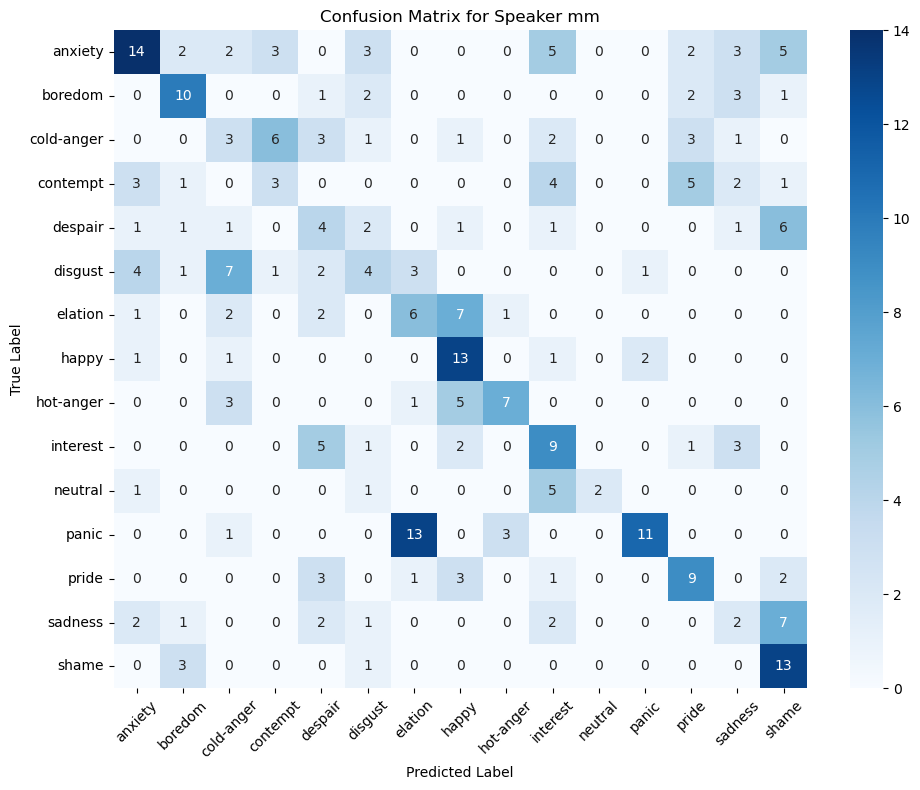


==== Speaker cc (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.04      0.10      0.06        10
     boredom       0.08      0.13      0.10        15
  cold-anger       0.08      0.07      0.07        15
    contempt       0.26      0.27      0.27        22
     despair       0.08      0.11      0.10         9
     disgust       0.35      0.23      0.27        31
     elation       0.21      0.25      0.23        16
       happy       0.40      0.35      0.37        23
   hot-anger       0.31      0.64      0.42        14
    interest       0.24      0.24      0.24        17
     neutral       0.90      0.50      0.64        18
       panic       0.62      0.44      0.52        18
       pride       0.40      0.17      0.24        23
     sadness       0.15      0.15      0.15        13
       shame       0.22      0.19      0.21        21

    accuracy                           0.26       265
   macro avg       0.29      0.26      0.26       26

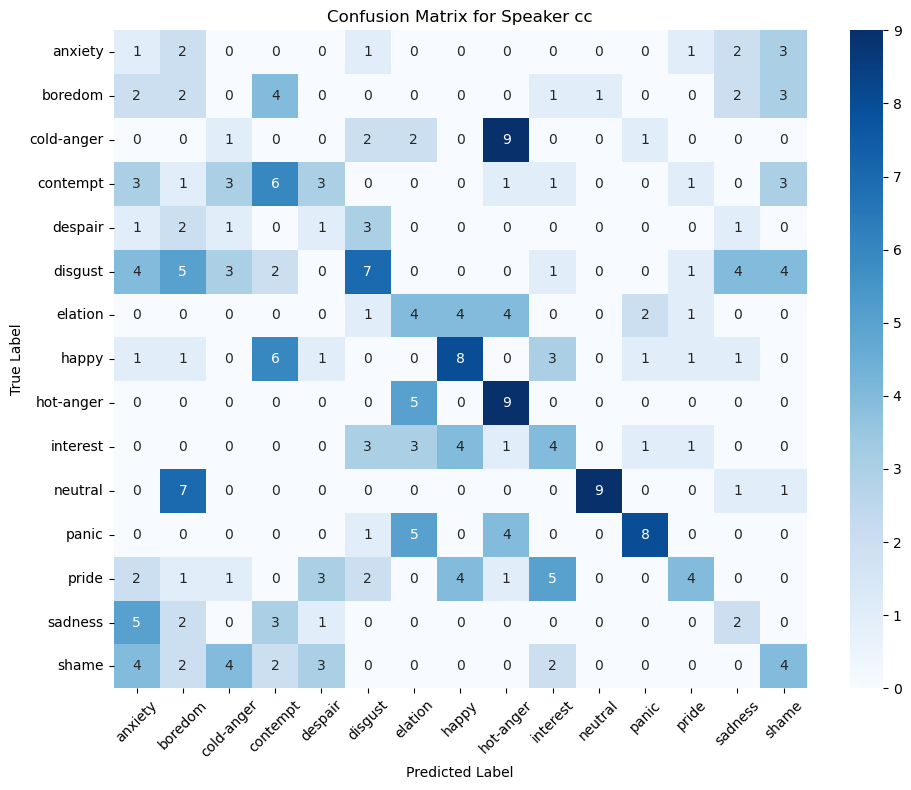


==== Speaker mf (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.36      0.36      0.36        22
     boredom       0.27      0.26      0.26        27
  cold-anger       0.09      0.10      0.09        20
    contempt       0.60      0.34      0.43        44
     despair       0.13      0.19      0.15        16
     disgust       0.04      1.00      0.08         1
     elation       0.00      0.00      0.00        26
       happy       0.13      0.09      0.11        23
   hot-anger       0.42      0.48      0.44        21
    interest       0.12      0.11      0.11        19
     neutral       0.64      0.90      0.75        10
       panic       0.37      0.58      0.45        12
       pride       0.15      0.11      0.13        18
     sadness       0.11      0.10      0.10        20
       shame       0.39      0.35      0.37        20

    accuracy                           0.26       299
   macro avg       0.26      0.33      0.26       29

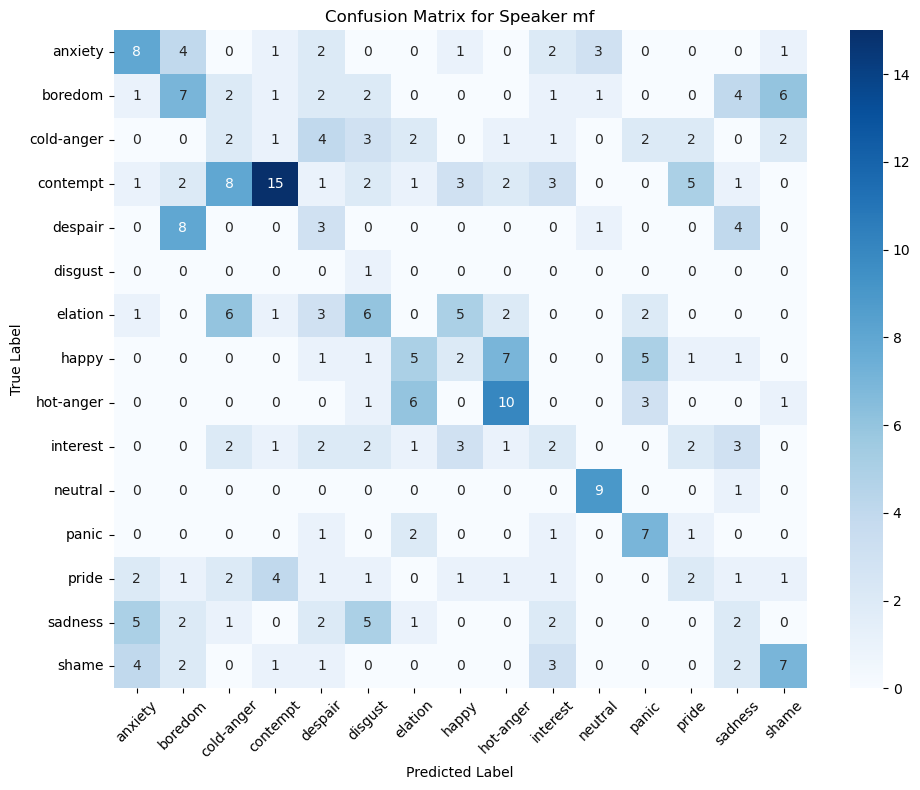


==== Speaker cl (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.19      0.19      0.19        21
     boredom       0.37      0.79      0.50        29
  cold-anger       0.56      0.37      0.44        27
    contempt       0.28      0.32      0.30        25
     despair       0.27      0.14      0.18        29
     disgust       0.21      0.18      0.20        22
     elation       0.33      0.33      0.33        27
       happy       0.47      0.33      0.39        21
   hot-anger       0.55      0.65      0.60        26
    interest       0.32      0.27      0.29        26
     neutral       1.00      0.12      0.21        17
       panic       0.23      0.14      0.18        21
       pride       0.43      0.25      0.32        24
     sadness       0.09      0.07      0.08        27
       shame       0.23      0.50      0.32        26

    accuracy                           0.32       368
   macro avg       0.37      0.31      0.30       36

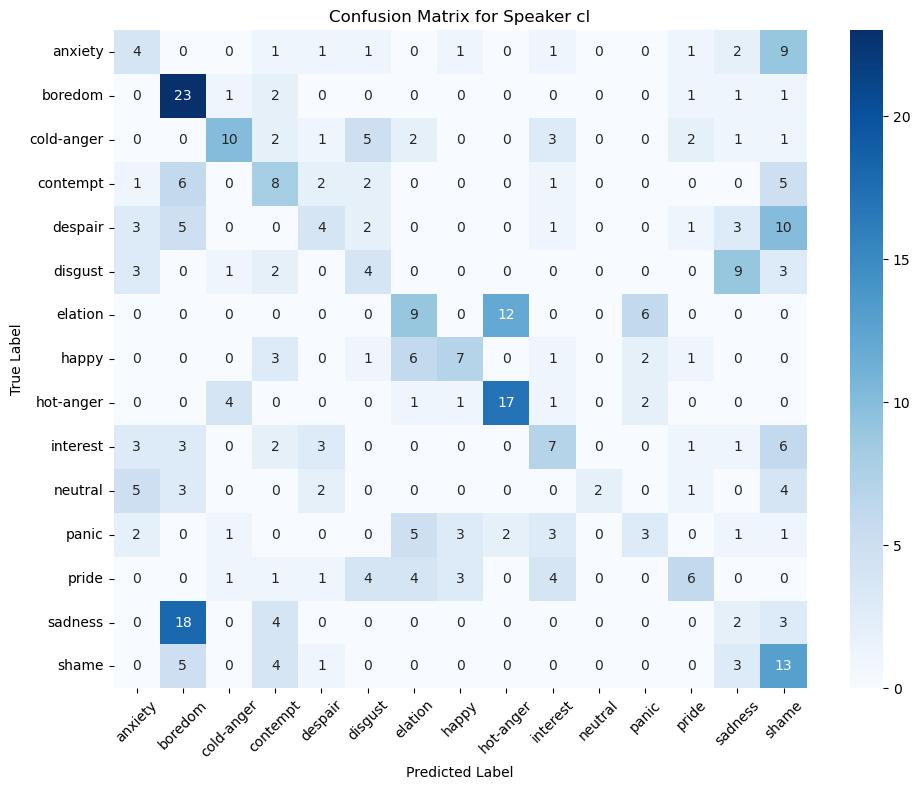


==== Speaker mk (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.09      0.10      0.10        29
     boredom       0.07      0.05      0.06        20
  cold-anger       0.19      0.30      0.24        23
    contempt       0.22      0.24      0.23        21
     despair       0.29      0.11      0.16        53
     disgust       0.18      0.14      0.16        21
     elation       0.23      0.43      0.30        23
       happy       0.27      0.29      0.28        42
   hot-anger       0.40      0.36      0.38        22
    interest       0.36      0.30      0.33        44
     neutral       0.75      0.75      0.75         8
       panic       0.46      0.52      0.49        21
       pride       0.09      0.09      0.09        23
     sadness       0.11      0.14      0.12        22
       shame       0.44      0.48      0.46        25

    accuracy                           0.26       397
   macro avg       0.28      0.29      0.28       39

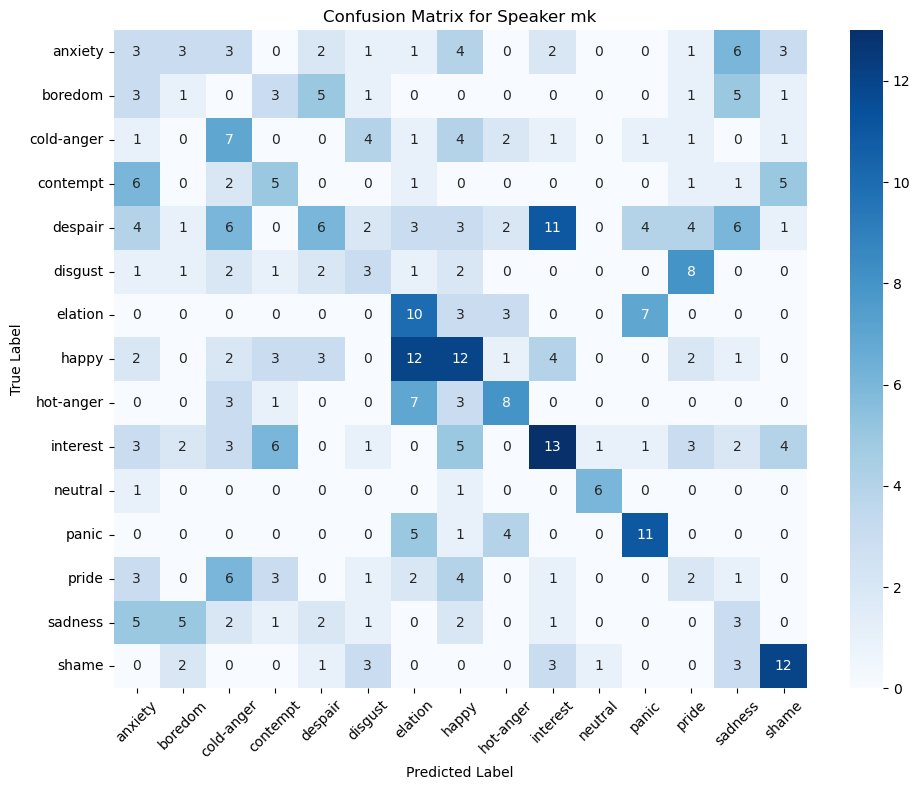


==== Speaker jg (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.17      0.21      0.19        19
     boredom       0.42      0.36      0.38        14
  cold-anger       0.17      0.14      0.15        22
    contempt       0.29      0.17      0.22        23
     despair       0.10      0.14      0.12        21
     disgust       0.32      0.26      0.29        23
     elation       0.25      0.15      0.19        20
       happy       0.12      0.10      0.11        20
   hot-anger       0.32      0.50      0.39        18
    interest       0.17      0.21      0.19        19
     neutral       0.20      0.12      0.15         8
       panic       0.12      0.07      0.09        14
       pride       0.12      0.22      0.16        18
     sadness       0.33      0.26      0.29        19
       shame       0.07      0.07      0.07        15

    accuracy                           0.20       273
   macro avg       0.21      0.20      0.20       27

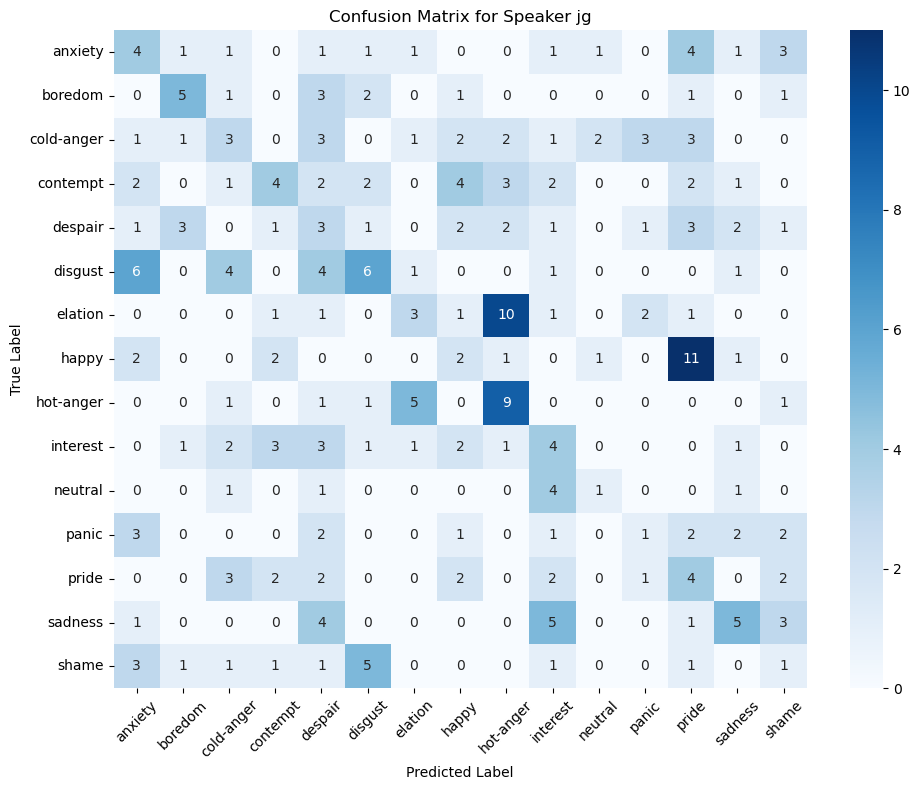


==== Speaker gg (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.41      0.43      0.42        30
     boredom       0.31      0.40      0.35        30
  cold-anger       0.22      0.37      0.27        27
    contempt       0.44      0.46      0.45        26
     despair       0.16      0.11      0.13        28
     disgust       0.57      0.25      0.35        51
     elation       0.62      0.71      0.67        28
       happy       0.28      0.53      0.37        30
   hot-anger       0.65      0.68      0.67        22
    interest       0.24      0.27      0.25        30
     neutral       0.50      0.11      0.18         9
       panic       0.70      0.52      0.60        27
       pride       0.23      0.20      0.21        25
     sadness       0.00      0.00      0.00        33
       shame       0.23      0.29      0.25        24

    accuracy                           0.35       420
   macro avg       0.37      0.36      0.34       42

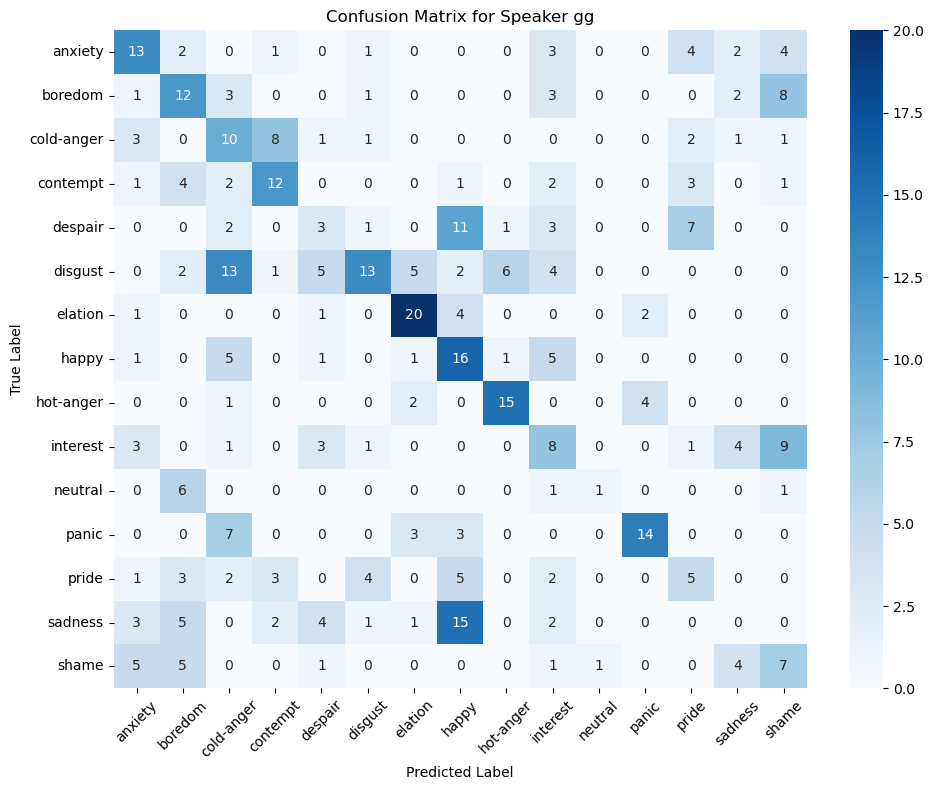


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2935
SVM Aggregated Weighted F1: 0.2890


In [227]:
feature_columns = [col for col in merged_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]
clipped_merged_df = clip_outliers_after_normalization(merged_df, feature_columns, threshold=3)

results_df = leave_one_speaker_out_cv_v2_final(clipped_merged_df, feature_columns)

In [229]:
print(results_df)

  speaker  n_samples  accuracy        f1
0      mm        302  0.364238  0.359941
1      cc        265  0.264151  0.276347
2      mf        299  0.257525  0.258368
3      cl        368  0.323370  0.307063
4      mk        397  0.256927  0.251770
5      jg        273  0.201465  0.200408
6      gg        420  0.354762  0.344517


In [473]:
merged_df

,filename,speaker,emotion,content,pcm_RMSenergy_sma_min,pcm_fftMag_mfcc_sma[2]_amean,pcm_fftMag_mfcc_sma[1]_max,pcm_fftMag_mfcc_sma[2]_min,pcm_fftMag_mfcc_sma[1]_amean,pcm_fftMag_mfcc_sma[10]_amean,...,pitch_min_norm,pitch_max_norm,pitch_mean_norm,intensity_mean_norm,jitter,shimmer,hnr,asr_confidence,content_ratio,pitch_variation
0,mm_001_happy_2353.51_three-hundred-nine.wav,mm,7,three-hundred-nine,-0.515106,-0.039062,0.276097,-0.844118,0.681456,0.169825,...,-0.439394,1.936789,0.298784,-0.501298,-0.868412,-1.433819,1.925809,0.713928,0.166667,0.568801
1,mm_001_panic_3395.30_one-thousand-three.wav,mm,11,one-thousand-three,-0.627824,-1.878861,-2.432082,-1.652900,-2.133865,2.260613,...,1.397019,3.419554,2.476506,-0.095500,-1.698528,-1.392501,2.261211,-1.719878,0.166667,4.054123
2,cc_001_panic_861.97_Two-thousand-five.wav,cc,11,Two-thousand-five,-0.882515,-0.059154,1.305762,-2.058033,0.414096,0.693616,...,-0.883233,1.523966,-0.226155,-1.926496,-0.883368,0.032906,-0.412700,1.006174,0.176471,-0.281480
3,mf_001_contempt_3901.86_November-first.wav,mf,3,November-first,-0.614879,-0.873147,0.839075,-1.084001,0.032289,2.276217,...,-0.845771,-0.303794,-0.550749,-0.134823,-0.624291,0.074119,-0.023180,1.074058,0.142857,-0.466594
4,cl_001_interest_1035.82_Ten-thousand-one.wav,cl,9,Ten-thousand-one,0.438028,2.006412,0.523187,1.067177,1.511678,-1.237865,...,-0.668688,-0.057844,-0.452563,0.416710,0.593357,0.408617,0.562819,-0.785203,0.187500,-0.729445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,gg_001_anxiety_861.72_Three-thousand-eight.wav,gg,0,Three-thousand-eight,-0.501734,1.520307,-0.763996,1.370108,-0.258356,-0.842831,...,-1.145647,0.873858,-0.146116,-0.646566,1.082093,-0.080714,-0.111534,0.284855,0.150000,-0.211869
2320,cl_001_cold-anger_499.97_March-twenty-third.wav,cl,2,March-twenty-third,0.153978,0.352554,1.221355,0.715401,0.345567,-0.333818,...,-0.764369,0.068233,-0.328794,0.343832,0.688183,-0.372136,-0.314024,0.909576,0.166667,-0.520576
2321,mm_001_elation_2227.76_nineteen-hundred.wav,mm,6,nineteen-hundred,-0.362226,-0.139043,-1.057743,-0.110149,0.216844,-1.985642,...,-0.411243,0.674862,-0.030901,0.442043,0.229852,-1.208033,0.778519,-1.606673,0.125000,0.057644
2322,jg_001_panic_425.32_August-fourteenth.wav,jg,11,August-fourteenth,-0.333691,0.318177,1.234293,0.999748,-0.021712,-1.655060,...,-1.847236,3.737951,-0.071353,-0.691872,5.286335,3.679317,-2.642028,0.904335,0.117647,-0.084990


In [419]:
for feature in ['jitter', 'shimmer', 'asr_confidence']:
    merged_df[feature] = normalize_feature_by_speaker(merged_df, feature)

In [231]:
feature_columns = [col for col in merged_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]
results_df = leave_one_speaker_out_cv_v2_noReport(merged_df, feature_columns)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2960
SVM Aggregated Weighted F1: 0.2928


In [233]:
# merged + noramlized + clipped
clipped_merged_df = clip_outliers_after_normalization(merged_df, feature_columns, threshold=3)
results_df = leave_one_speaker_out_cv_v2_noReport(clipped_merged_df, feature_columns)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2935
SVM Aggregated Weighted F1: 0.2890


In [235]:
# merged + normalized + balancing
results_df = leave_one_speaker_out_cv_v2_smote(merged_df, feature_columns)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2904
SVM Aggregated Weighted F1: 0.2871


In [237]:
# merged + noramlized + clipped + oversampling
results_df = leave_one_speaker_out_cv_v2_smote(clipped_merged_df, feature_columns)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2926
SVM Aggregated Weighted F1: 0.2907


save normalized merged features (to use further feature engineering directly)

In [239]:
# 200 features from opensmile + additional (text+speech) features
merged_df.to_csv("../task2_normalized_features.csv", index=False) # only normalized

In [6]:
# load directly
merged_df = pd.read_csv("../task2_normalized_features.csv")

In [20]:
feature_columns = [col for col in merged_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]
clipped_merged_df = clip_outliers_after_normalization(merged_df, feature_columns, threshold=3)

In [22]:
merged_df

,filename,speaker,emotion,content,pcm_RMSenergy_sma_min,pcm_fftMag_mfcc_sma[1]_max,pcm_fftMag_mfcc_sma[2]_amean,pcm_fftMag_mfcc_sma[1]_amean,pcm_fftMag_mfcc_sma[6]_amean,pcm_fftMag_mfcc_sma[2]_min,...,pitch_min_norm,pitch_max_norm,pitch_mean_norm,intensity_mean_norm,jitter,shimmer,hnr,asr_confidence,content_ratio,pitch_variation
0,mm_001_happy_2353.51_three-hundred-nine.wav,mm,7,three-hundred-nine,-0.515106,0.276097,-0.039062,0.681456,-1.669598,-0.844118,...,-0.439394,1.936789,0.298784,-0.501298,-0.868412,-1.433819,1.925809,0.713928,0.166667,0.568801
1,mm_001_panic_3395.30_one-thousand-three.wav,mm,11,one-thousand-three,-0.627824,-2.432082,-1.878861,-2.133865,-0.600219,-1.652900,...,1.397019,3.419554,2.476506,-0.095500,-1.698528,-1.392501,2.261211,-1.719878,0.166667,4.054123
2,cc_001_panic_861.97_Two-thousand-five.wav,cc,11,Two-thousand-five,-0.882515,1.305762,-0.059154,0.414096,0.903443,-2.058033,...,-0.883233,1.523966,-0.226155,-1.926496,-0.883368,0.032906,-0.412700,1.006174,0.176471,-0.281480
3,mf_001_contempt_3901.86_November-first.wav,mf,3,November-first,-0.614879,0.839075,-0.873147,0.032289,-0.205403,-1.084001,...,-0.845771,-0.303794,-0.550749,-0.134823,-0.624291,0.074119,-0.023180,1.074058,0.142857,-0.466594
4,cl_001_interest_1035.82_Ten-thousand-one.wav,cl,9,Ten-thousand-one,0.438028,0.523187,2.006412,1.511678,1.534524,1.067177,...,-0.668688,-0.057844,-0.452563,0.416710,0.593357,0.408617,0.562819,-0.785203,0.187500,-0.729445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,gg_001_anxiety_861.72_Three-thousand-eight.wav,gg,0,Three-thousand-eight,-0.501734,-0.763996,1.520307,-0.258356,0.276169,1.370108,...,-1.145647,0.873858,-0.146116,-0.646566,1.082093,-0.080714,-0.111534,0.284855,0.150000,-0.211869
2320,cl_001_cold-anger_499.97_March-twenty-third.wav,cl,2,March-twenty-third,0.153978,1.221355,0.352554,0.345567,-0.869832,0.715401,...,-0.764369,0.068233,-0.328794,0.343832,0.688183,-0.372136,-0.314024,0.909576,0.166667,-0.520576
2321,mm_001_elation_2227.76_nineteen-hundred.wav,mm,6,nineteen-hundred,-0.362226,-1.057743,-0.139043,0.216844,-1.308869,-0.110149,...,-0.411243,0.674862,-0.030901,0.442043,0.229852,-1.208033,0.778519,-1.606673,0.125000,0.057644
2322,jg_001_panic_425.32_August-fourteenth.wav,jg,11,August-fourteenth,-0.333691,1.234293,0.318177,-0.021712,1.519205,0.999748,...,-1.847236,3.737951,-0.071353,-0.691872,5.286335,3.679317,-2.642028,0.904335,0.117647,-0.084990


In [71]:
clipped_merged_df.shape

(2324, 214)

In [24]:
acc_scores = []
f1_scores = []

k_list = [50, 100, 150, 160, 170, 180, 190, 200]
feature_columns = [col for col in merged_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]

for k in k_list:
    top_features_k = select_top_k_features_by_importance_noReport(clipped_merged_df, feature_columns, label_column='emotion', k=k)
    aggregated_accuracy, aggregated_f1 = leave_one_speaker_out_cv_v2_noReport(clipped_merged_df, top_features_k)

    acc_scores.append(aggregated_accuracy)
    f1_scores.append(aggregated_f1)
    
com2 = pd.DataFrame({
    'k': k_list,
    'Aggregated Accuracy': acc_scores,
    'Aggregated F1': f1_scores
})


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2668
SVM Aggregated Weighted F1: 0.2629

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2767
SVM Aggregated Weighted F1: 0.2718

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2917
SVM Aggregated Weighted F1: 0.2867

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2857
SVM Aggregated Weighted F1: 0.2818

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2917
SVM Aggregated Weighted F1: 0.2875

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.3003
SVM Aggregated Weighted F1: 0.2977

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2896
SVM Aggregated Weighted F1: 0.2868

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2991
SVM Aggregated Weighted F1: 0.2947


In [26]:
com2 # 180 0.3003, 0.2977

,k,Aggregated Accuracy,Aggregated F1
0,50,0.266781,0.262909
1,100,0.276678,0.271831
2,150,0.291738,0.286739
3,160,0.285714,0.281797
4,170,0.291738,0.287513
5,180,0.300344,0.297668
6,190,0.289587,0.286815
7,200,0.299053,0.294689


In [28]:
acc_scores = []
f1_scores = []

k_list = [175, 180, 185]
feature_columns = [col for col in merged_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]

for k in k_list:
    top_features_k = select_top_k_features_by_importance_noReport(clipped_merged_df, feature_columns, label_column='emotion', k=k)
    aggregated_accuracy, aggregated_f1 = leave_one_speaker_out_cv_v2_noReport(clipped_merged_df, top_features_k)

    acc_scores.append(aggregated_accuracy)
    f1_scores.append(aggregated_f1)
    
com2 = pd.DataFrame({
    'k': k_list,
    'Aggregated Accuracy': acc_scores,
    'Aggregated F1': f1_scores
})


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2917
SVM Aggregated Weighted F1: 0.2880

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.3003
SVM Aggregated Weighted F1: 0.2977

--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2965
SVM Aggregated Weighted F1: 0.2930


In [30]:
com2

,k,Aggregated Accuracy,Aggregated F1
0,175,0.291738,0.287952
1,180,0.300344,0.297668
2,185,0.296472,0.293024


feature k: 180

merged + clipping + feature 180:: acc 0.3003, f1 0.2976

In [83]:
# top k: 180 -> merged + clipping + oversampling
top_features_k = select_top_k_features_by_importance_noReport(clipped_merged_df, feature_columns, label_column='emotion', k=180)
result_df = leave_one_speaker_out_cv_v2_smote(clipped_merged_df, top_features_k)


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.2999
SVM Aggregated Weighted F1: 0.2970



==== Speaker mm (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.57      0.31      0.40        39
     boredom       0.47      0.42      0.44        19
  cold-anger       0.16      0.15      0.15        20
    contempt       0.33      0.21      0.26        19
     despair       0.17      0.22      0.20        18
     disgust       0.32      0.26      0.29        23
     elation       0.27      0.32      0.29        19
       happy       0.39      0.72      0.51        18
   hot-anger       0.60      0.38      0.46        16
    interest       0.25      0.33      0.29        21
     neutral       1.00      0.22      0.36         9
       panic       0.75      0.43      0.55        28
       pride       0.41      0.47      0.44        19
     sadness       0.18      0.24      0.21        17
       shame       0.36      0.76      0.49        17

    accuracy                           0.36       302
   macro avg       0.42      0.36      0.36       30

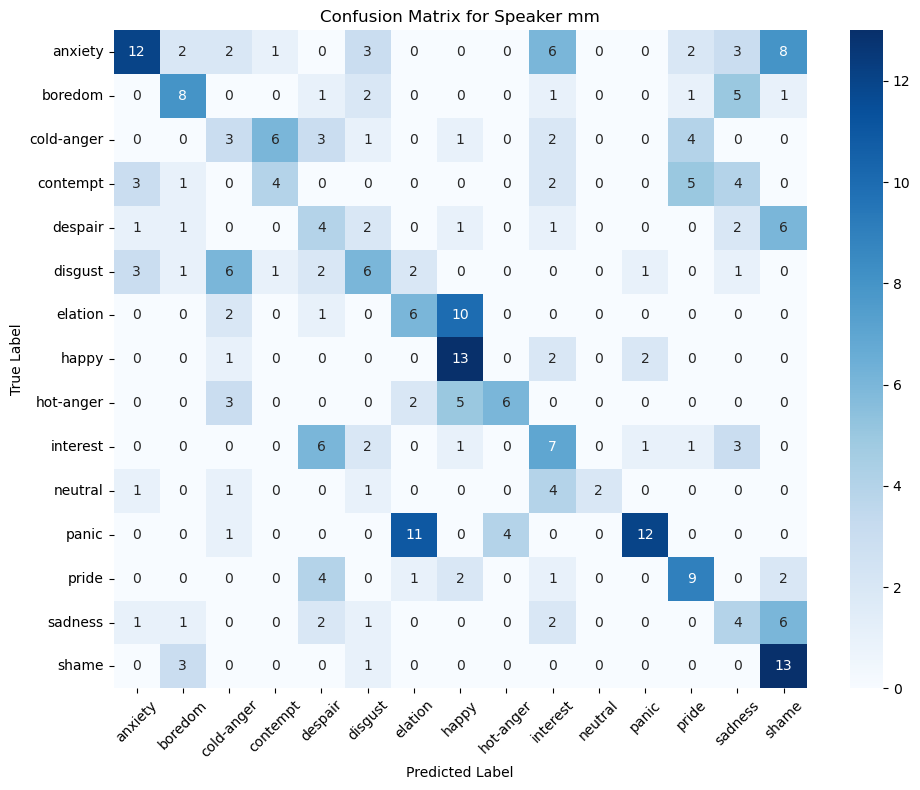


==== Speaker cc (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.05      0.10      0.07        10
     boredom       0.06      0.13      0.08        15
  cold-anger       0.08      0.07      0.07        15
    contempt       0.34      0.45      0.39        22
     despair       0.07      0.11      0.09         9
     disgust       0.42      0.26      0.32        31
     elation       0.21      0.25      0.23        16
       happy       0.37      0.30      0.33        23
   hot-anger       0.38      0.71      0.50        14
    interest       0.21      0.18      0.19        17
     neutral       0.75      0.33      0.46        18
       panic       0.60      0.50      0.55        18
       pride       0.50      0.22      0.30        23
     sadness       0.15      0.15      0.15        13
       shame       0.29      0.19      0.23        21

    accuracy                           0.28       265
   macro avg       0.30      0.26      0.26       26

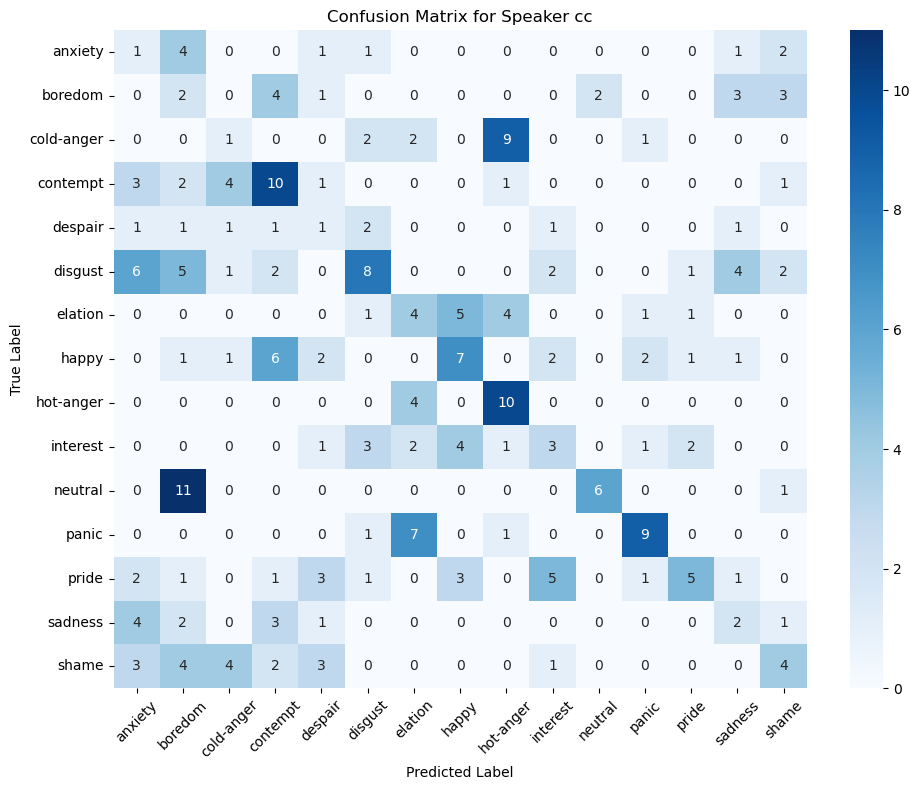


==== Speaker mf (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.36      0.45      0.40        22
     boredom       0.32      0.26      0.29        27
  cold-anger       0.08      0.10      0.09        20
    contempt       0.61      0.39      0.47        44
     despair       0.16      0.19      0.17        16
     disgust       0.04      1.00      0.07         1
     elation       0.05      0.04      0.04        26
       happy       0.13      0.09      0.11        23
   hot-anger       0.47      0.43      0.45        21
    interest       0.08      0.05      0.06        19
     neutral       0.67      1.00      0.80        10
       panic       0.37      0.58      0.45        12
       pride       0.06      0.06      0.06        18
     sadness       0.11      0.10      0.11        20
       shame       0.36      0.25      0.29        20

    accuracy                           0.26       299
   macro avg       0.26      0.33      0.26       29

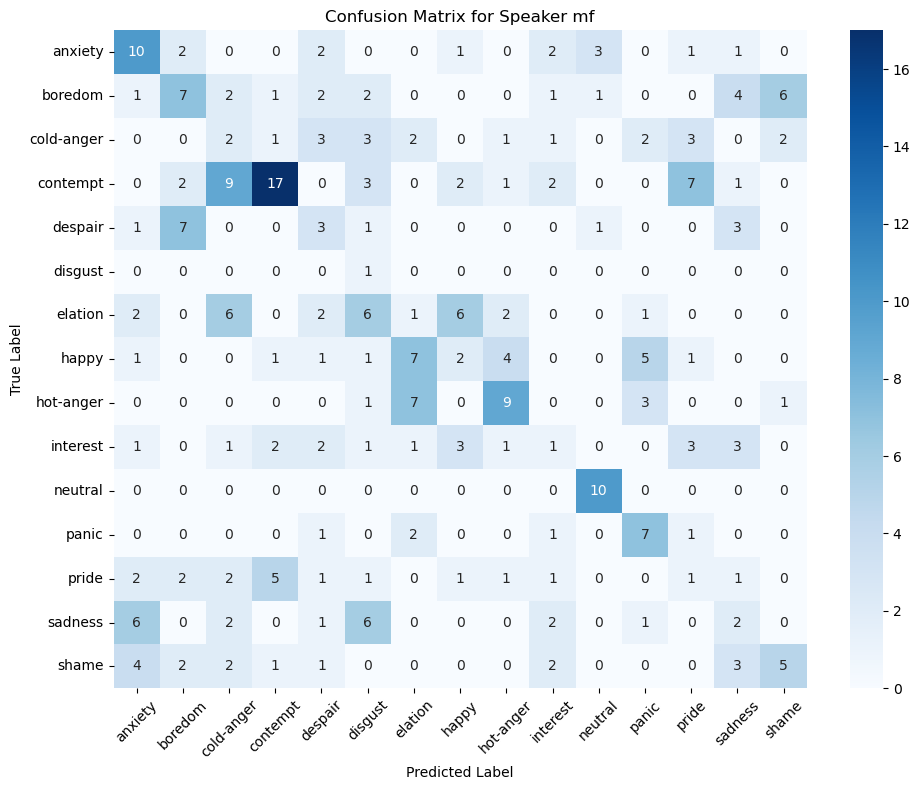


==== Speaker cl (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.23      0.33      0.27        21
     boredom       0.42      0.79      0.55        29
  cold-anger       0.69      0.41      0.51        27
    contempt       0.26      0.24      0.25        25
     despair       0.33      0.21      0.26        29
     disgust       0.27      0.18      0.22        22
     elation       0.27      0.30      0.28        27
       happy       0.33      0.24      0.28        21
   hot-anger       0.63      0.65      0.64        26
    interest       0.33      0.27      0.30        26
     neutral       1.00      0.06      0.11        17
       panic       0.24      0.19      0.21        21
       pride       0.40      0.33      0.36        24
     sadness       0.16      0.15      0.15        27
       shame       0.22      0.46      0.30        26

    accuracy                           0.33       368
   macro avg       0.39      0.32      0.31       36

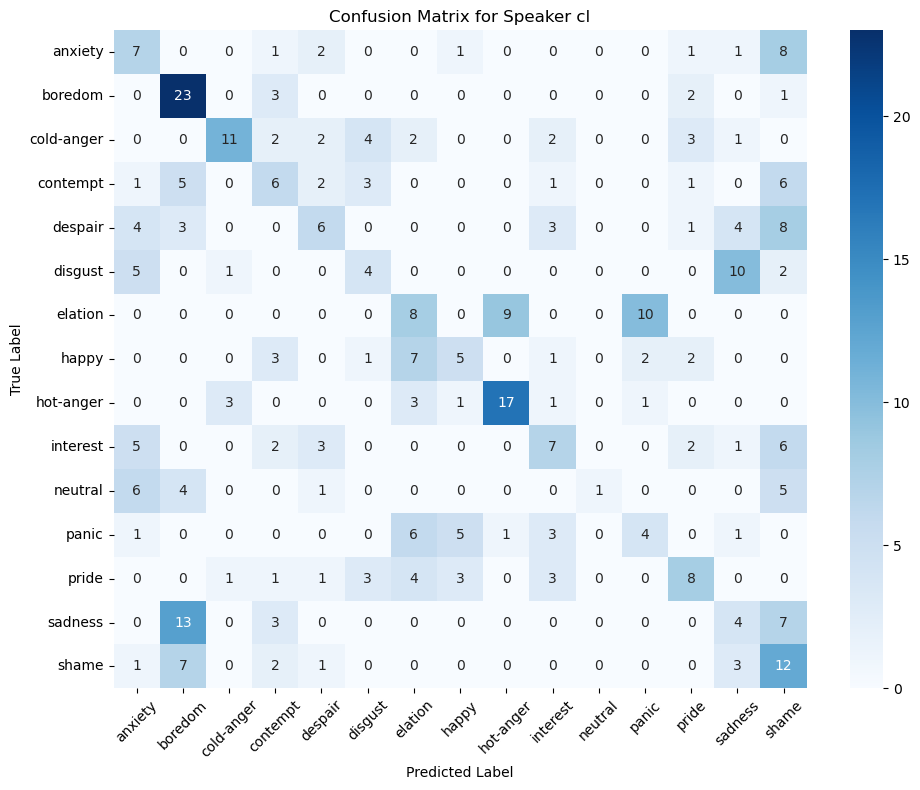


==== Speaker mk (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.06      0.07      0.06        29
     boredom       0.07      0.05      0.06        20
  cold-anger       0.20      0.35      0.25        23
    contempt       0.22      0.19      0.21        21
     despair       0.35      0.17      0.23        53
     disgust       0.27      0.19      0.22        21
     elation       0.27      0.52      0.36        23
       happy       0.27      0.24      0.25        42
   hot-anger       0.44      0.32      0.37        22
    interest       0.34      0.27      0.30        44
     neutral       0.78      0.88      0.82         8
       panic       0.50      0.57      0.53        21
       pride       0.15      0.17      0.16        23
     sadness       0.14      0.18      0.16        22
       shame       0.32      0.36      0.34        25

    accuracy                           0.26       397
   macro avg       0.29      0.30      0.29       39

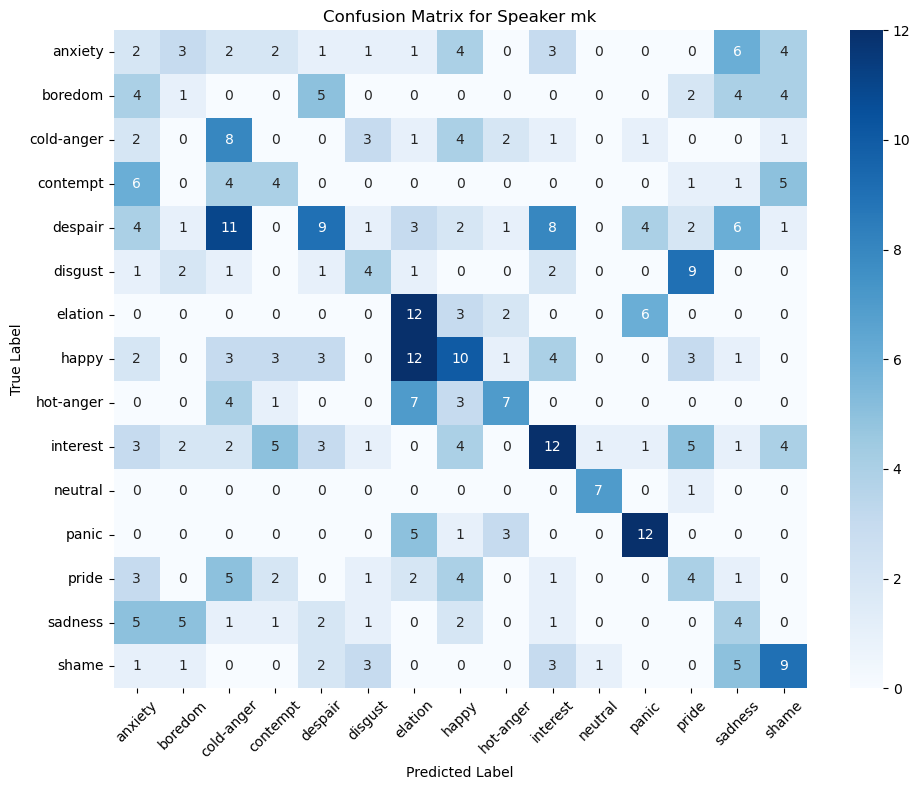


==== Speaker jg (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.20      0.16      0.18        19
     boredom       0.36      0.36      0.36        14
  cold-anger       0.22      0.18      0.20        22
    contempt       0.24      0.17      0.20        23
     despair       0.18      0.24      0.20        21
     disgust       0.35      0.30      0.33        23
     elation       0.23      0.15      0.18        20
       happy       0.16      0.15      0.15        20
   hot-anger       0.24      0.33      0.28        18
    interest       0.19      0.26      0.22        19
     neutral       0.00      0.00      0.00         8
       panic       0.11      0.07      0.09        14
       pride       0.09      0.17      0.11        18
     sadness       0.32      0.32      0.32        19
       shame       0.08      0.07      0.07        15

    accuracy                           0.21       273
   macro avg       0.20      0.20      0.19       27

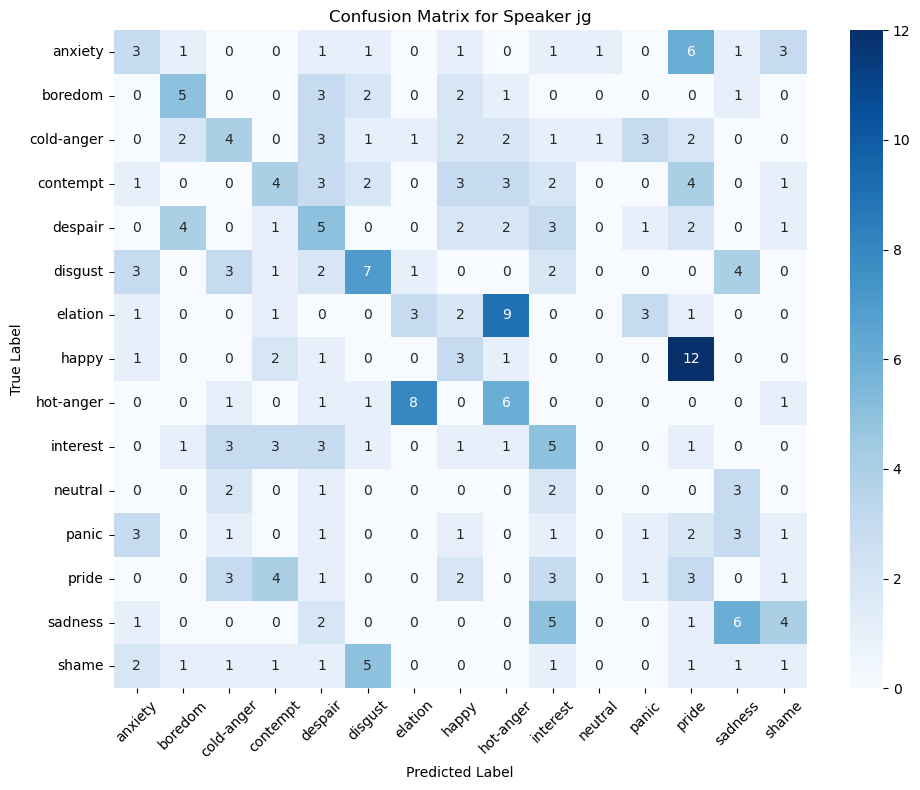


==== Speaker gg (SVM) ====
              precision    recall  f1-score   support

     anxiety       0.45      0.50      0.48        30
     boredom       0.34      0.40      0.37        30
  cold-anger       0.22      0.37      0.28        27
    contempt       0.35      0.35      0.35        26
     despair       0.19      0.14      0.16        28
     disgust       0.62      0.31      0.42        51
     elation       0.66      0.75      0.70        28
       happy       0.28      0.57      0.37        30
   hot-anger       0.74      0.77      0.76        22
    interest       0.21      0.23      0.22        30
     neutral       1.00      0.11      0.20         9
       panic       0.78      0.52      0.62        27
       pride       0.16      0.16      0.16        25
     sadness       0.00      0.00      0.00        33
       shame       0.26      0.29      0.27        24

    accuracy                           0.37       420
   macro avg       0.42      0.37      0.36       42

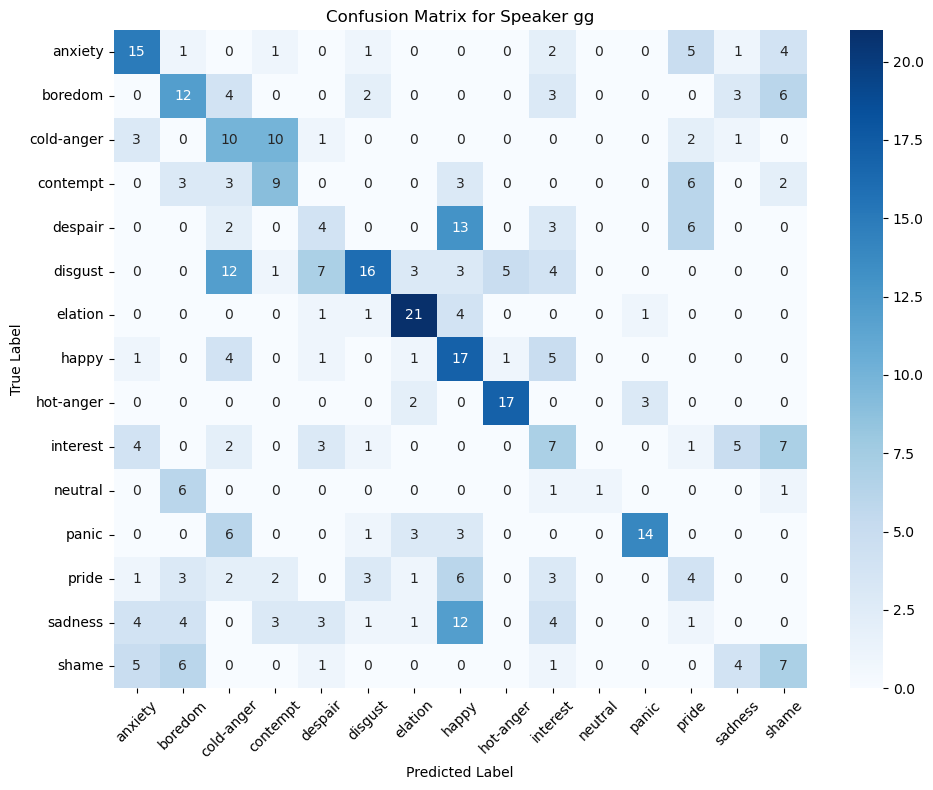


--- Aggregated Results ---
SVM Aggregated Accuracy: 0.3003
SVM Aggregated Weighted F1: 0.2977


In [85]:
# top k: 180 -> merged + clipping + (no oversampling)
feature_columns = [col for col in merged_df.columns if col not in ['filename', 'speaker', 'emotion', 'content']]
top_features_k = select_top_k_features_by_importance_noReport(clipped_merged_df, feature_columns, label_column='emotion', k=180)
result_df = leave_one_speaker_out_cv_v2_final(clipped_merged_df, top_features_k)

In [87]:
result_df

,speaker,n_samples,accuracy,f1
0,mm,302,0.360927,0.360742
1,cc,265,0.275472,0.286293
2,mf,299,0.260870,0.262450
3,cl,368,0.334239,0.322287
4,mk,397,0.264484,0.260877
5,jg,273,0.205128,0.202976
6,gg,420,0.366667,0.359321
